In [2]:
#import libraries
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
#Mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Look through all folders in the "Project" folder on Google Drive to access dataset
folder_path = '/content/drive/MyDrive/Project'

data = []

for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith('.txt'):
            file_path = os.path.join(root, filename)
            date = os.path.splitext(filename)[0]  # Extract date from filename
            try:
                df = pd.read_csv(file_path, delimiter='\s+', skiprows=[0, 2], encoding='latin1')
                df = df.iloc[:, :16]
                df.columns = ['Time', 'Wind Dir', 'Wind Spd', 'Hum In', 'Humidity', 'Temp In', 'Temp', 'Raw Barom', 'Temp Ch1', 'Hum Ch1', 'Temp Ch2', 'Hum Ch2', 'UV', 'Solar Radiation', 'Dew Point', 'Rain Rate']
                df.insert(0, 'Date', pd.to_datetime(date, format='%y%m%d').strftime('%d-%m-%y'))

                data.append(df)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

Error processing file /content/drive/MyDrive/Project/Dataset_3/120825.txt: No columns to parse from file
Error processing file /content/drive/MyDrive/Project/Dataset_3/121220.txt: Error tokenizing data. C error: Expected 30 fields in line 689, saw 31



In [5]:
# Concatenate all data into a single DataFrame
data = pd.concat(data, ignore_index=True)

# Convert 'date' and 'Time' columns to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%y')
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M').dt.time
data.sort_values(by=['Date', 'Time'], inplace=True)
data.set_index('Date', inplace=True)

In [6]:
# Extract data from 16th Jan 2015
met_data = data.loc['2015-01-16':]
met_data = met_data.iloc[:, :14]
met_data.columns = ['Time', 'Wind Dir', 'Wind Spd', 'Wind Gust', 'Hum In', 'Humidity', 'Temp In', 'Temp', 'Raw Barom', 'UV', 'Solar Radiation', 'Dew Point', 'Daily Rain', 'Rain Rate']

In [7]:
#Add the time to the date and set as index
met_data.index = pd.to_datetime(met_data.index, format='%Y-%m-%d')
met_data['Time'] = pd.to_datetime(met_data['Time'], format='%H:%M:%S').dt.time

date_str = met_data.index.date.astype(str)
time_str = met_data['Time'].astype(str)
datetime_str = [f"{date} {time}" for date, time in zip(date_str, time_str)]
met_data.index = pd.to_datetime(datetime_str)
met_data.drop(columns=['Time'], inplace=True) # Drop the old 'Time' column
met_data

Wind Dir  Wind Spd  Wind Gust  Hum In  Humidity  Temp In  \
2015-01-16 00:00:00     241.0      11.3       25.7    42.0      77.0    13.90   
2015-01-16 00:01:00     218.0       8.0       17.7    42.0      77.0    13.90   
2015-01-16 00:02:00     240.0      11.3       19.3    42.0      77.0    13.90   
2015-01-16 00:03:00     228.0       8.0       14.5    42.0      77.0    13.90   
2015-01-16 00:04:00     216.0      17.7       20.9    42.0      77.0    13.90   
...                       ...       ...        ...     ...       ...      ...   
2024-05-21 23:24:00     268.0       0.0        0.0    68.0      96.0    18.06   
2024-05-21 23:25:00     268.0       0.0        1.6    68.0      96.0    17.94   
2024-05-21 23:26:00     268.0       1.6        1.6    68.0      96.0    17.94   
2024-05-21 23:27:00     268.0       1.6        3.2    68.0      96.0    17.94   
2024-05-21 23:28:00     268.0       0.0        3.2    68.0      96.0    17.94   

                      Temp  Raw Barom   UV  Solar Radiation  Dew Point  \
2015-01-16 00:00:00   4.80     990.10  0.0              0.0       1.10   
2015-01-16 00:01:00   4.80     990.00  0.0              0.0       1.10   
2015-01-16 00:02:00   4.80     990.10  0.0              0.0       1.10   
2015-01-16 00:03:00   4.80     990.10  0.0              0.0       1.10   
2015-01-16 00:04:00   4.80     990.20  0.0              0.0       1.10   
...                    ...        ...  ...              ...        ...   
2024-05-21 23:24:00  13.78    1000.73  0.0              0.0      13.15   
2024-05-21 23:25:00  13.78    1000.69  0.0              0.0      13.15   
2024-05-21 23:26:00  13.78    1000.63  0.0              0.0      13.15   
2024-05-21 23:27:00  13.78    1000.63  0.0              0.0      13.15   
2024-05-21 23:28:00  13.78    1000.63  0.0              0.0      13.15   

                     Daily Rain  Rain Rate  
2015-01-16 00:00:00         8.6        0.0  
2015-01-16 00:01:00         0.0        0.0  
2015-01-16 00:02:00         0.0        0.0  
2015-01-16 00:03:00         0.0        0.0  
2015-01-16 00:04:00         0.0        0.0  
...                         ...        ...  
2024-05-21 23:24:00        13.0        0.0  
2024-05-21 23:25:00        13.0        0.0  
2024-05-21 23:26:00        13.0        0.0  
2024-05-21 23:27:00        13.0        0.0  
2024-05-21 23:28:00        13.0        0.0  

[4719074 rows x 13 columns]

In [7]:
pd.set_option('display.max_info_columns', 100)
pd.set_option('display.max_info_rows', 10000000)
met_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4719074 entries, 2015-01-16 00:00:00 to 2024-05-21 23:28:00
Data columns (total 13 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Wind Dir         4719074 non-null  float64
 1   Wind Spd         4719074 non-null  float64
 2   Wind Gust        4719074 non-null  float64
 3   Hum In           4719074 non-null  float64
 4   Humidity         4719074 non-null  float64
 5   Temp In          4719074 non-null  float64
 6   Temp             4719074 non-null  float64
 7   Raw Barom        4719074 non-null  float64
 8   UV               4719074 non-null  float64
 9   Solar Radiation  4719074 non-null  float64
 10  Dew Point        4719074 non-null  float64
 11  Daily Rain       4719074 non-null  float64
 12  Rain Rate        4719074 non-null  float64
dtypes: float64(13)
memory usage: 504.1 MB


In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
met_data.describe()

Wind Dir   Wind Spd  Wind Gust     Hum In   Humidity    Temp In  \
count 4719074.00 4719074.00 4719074.00 4719074.00 4719074.00 4719074.00   
mean      203.25       4.97       8.92      55.58      83.42      17.34   
std        89.26       5.19       7.53      11.27      12.96       6.36   
min         0.00       0.00       0.00       0.00       0.00     -17.80   
25%       137.00       0.00       3.20      48.00      77.00      13.00   
50%       222.00       3.20       8.00      54.00      88.00      17.10   
75%       276.00       8.00      12.90      63.00      93.00      21.70   
max       359.00      66.00      74.00      86.00      98.00      40.89   

            Temp  Raw Barom         UV  Solar Radiation  Dew Point  \
count 4719074.00 4719074.00 4719074.00       4719074.00 4719074.00   
mean       10.79    1007.97       0.53           106.59       7.84   
std         6.08      25.76       1.06           186.26       5.01   
min       -17.80       0.00       0.00             0.00     -17.80   
25%         6.60    1002.00       0.00             0.00       4.30   
50%        10.44    1009.60       0.00             0.00       8.04   
75%        14.80    1016.00       0.60           137.00      11.60   
max        38.89    1042.60       9.00          1252.00      22.10   

       Daily Rain  Rain Rate  
count  4719074.00 4719074.00  
mean         0.79       0.06  
std          2.37       1.86  
min          0.00      -0.20  
25%          0.00       0.00  
50%          0.00       0.00  
75%          0.20       0.00  
max         38.20    1645.80

In [8]:
#create a dataframe containing daily data
daily_data = met_data.resample('D').agg({
    'Wind Dir': 'mean',
    'Wind Spd': 'mean',
    'Wind Gust': 'mean',
    'Hum In': 'mean',
    'Humidity': 'mean',
    'Temp In': 'mean',
    'Temp': 'mean',
    'Raw Barom': 'mean',
    'UV': 'mean',
    'Solar Radiation': 'mean',
    'Dew Point': 'mean',
    'Daily Rain': 'last',  # Use 'last' for Daily Rain
    'Rain Rate': 'mean'
})

In [ ]:
daily_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3414 entries, 2015-01-16 to 2024-05-21
Freq: D
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Wind Dir         3284 non-null   float64
 1   Wind Spd         3284 non-null   float64
 2   Wind Gust        3284 non-null   float64
 3   Hum In           3284 non-null   float64
 4   Humidity         3284 non-null   float64
 5   Temp In          3284 non-null   float64
 6   Temp             3284 non-null   float64
 7   Raw Barom        3284 non-null   float64
 8   UV               3284 non-null   float64
 9   Solar Radiation  3284 non-null   float64
 10  Dew Point        3284 non-null   float64
 11  Daily Rain       3284 non-null   float64
 12  Rain Rate        3284 non-null   float64
dtypes: float64(13)
memory usage: 373.4 KB


In [ ]:
daily_data.describe()

Wind Dir     Wind Spd    Wind Gust       Hum In     Humidity  \
count  3284.000000  3284.000000  3284.000000  3284.000000  3284.000000   
mean    203.264272     4.972348     8.924202    55.587041    83.418202   
std      63.219295     3.117562     5.141636    10.598749     8.316670   
min      19.418750     0.000000     0.000000    29.663889    46.528472   
25%     166.755382     2.654554     5.072569    48.090993    77.788970   
50%     216.215625     4.412917     8.017917    53.868358    84.341667   
75%     249.410937     6.667552    11.814757    62.353472    89.964583   
max     349.695139    22.161944    34.337431    83.018056    97.993750   

           Temp In         Temp    Raw Barom           UV  Solar Radiation  \
count  3284.000000  3284.000000  3284.000000  3284.000000      3284.000000   
mean     17.340694    10.796866  1007.848791     0.528728       106.618128   
std       5.982424     5.328628    26.865502     0.473064        80.473154   
min      -0.440278    -5.192306     0.000000     0.000000         0.000000   
25%      13.038299     6.932917  1001.905439     0.109306        35.322917   
50%      17.124340    10.500729  1009.616875     0.401632        88.241319   
75%      21.797656    14.937830  1015.767205     0.866406       167.023438   
max      35.280972    28.286438  1040.620694     2.478349       359.229665   

         Dew Point   Daily Rain    Rain Rate  
count  3284.000000  3284.000000  3284.000000  
mean      7.846581     1.608283     0.059188  
std       4.705269     3.488831     0.174272  
min      -6.711597     0.000000    -0.200000  
25%       4.368059     0.000000     0.000000  
50%       7.953229     0.200000     0.000000  
75%      11.480295     1.400000     0.036667  
max      19.140417    38.200000     5.058333

## **Handling** **Missing** **Values**

In [ ]:
#Find how many missing days are in the dataset
date_range = pd.date_range(start='2015-01-16', end='2024-05-21', freq='D')
unique_days = pd.to_datetime(met_data.index.date)
missing_days = date_range.difference(unique_days)

print(f"Number of missing days: {len(missing_days)}")
missing_days = pd.DataFrame(missing_days, columns=['Missing Date'])
missing_days

Number of missing days: 130


Missing Date
0     2019-05-27
1     2019-06-28
2     2019-06-29
3     2019-06-30
4     2019-07-01
..           ...
125   2019-10-30
126   2019-10-31
127   2019-11-01
128   2024-03-13
129   2024-03-27

[130 rows x 1 columns]

In [ ]:
#Find missing values in daily data
missing_values = daily_data[daily_data.isnull().any(axis=1)]
missing_values

Wind Dir  Wind Spd  Wind Gust  Hum In  Humidity  Temp In  Temp  \
2019-05-27       NaN       NaN        NaN     NaN       NaN      NaN   NaN   
2019-06-28       NaN       NaN        NaN     NaN       NaN      NaN   NaN   
2019-06-29       NaN       NaN        NaN     NaN       NaN      NaN   NaN   
2019-06-30       NaN       NaN        NaN     NaN       NaN      NaN   NaN   
2019-07-01       NaN       NaN        NaN     NaN       NaN      NaN   NaN   
...              ...       ...        ...     ...       ...      ...   ...   
2019-10-30       NaN       NaN        NaN     NaN       NaN      NaN   NaN   
2019-10-31       NaN       NaN        NaN     NaN       NaN      NaN   NaN   
2019-11-01       NaN       NaN        NaN     NaN       NaN      NaN   NaN   
2024-03-13       NaN       NaN        NaN     NaN       NaN      NaN   NaN   
2024-03-27       NaN       NaN        NaN     NaN       NaN      NaN   NaN   

            Raw Barom  UV  Solar Radiation  Dew Point  Daily Rain  Rain Rate  
2019-05-27        NaN NaN              NaN        NaN         NaN        NaN  
2019-06-28        NaN NaN              NaN        NaN         NaN        NaN  
2019-06-29        NaN NaN              NaN        NaN         NaN        NaN  
2019-06-30        NaN NaN              NaN        NaN         NaN        NaN  
2019-07-01        NaN NaN              NaN        NaN         NaN        NaN  
...               ...  ..              ...        ...         ...        ...  
2019-10-30        NaN NaN              NaN        NaN         NaN        NaN  
2019-10-31        NaN NaN              NaN        NaN         NaN        NaN  
2019-11-01        NaN NaN              NaN        NaN         NaN        NaN  
2024-03-13        NaN NaN              NaN        NaN         NaN        NaN  
2024-03-27        NaN NaN              NaN        NaN         NaN        NaN  

[130 rows x 13 columns]

In [ ]:
#check for percentage of missing values
missing_values_percentage = daily_data.isnull().mean()*100
missing_values_percentage

Wind Dir           3.80785
Wind Spd           3.80785
Wind Gust          3.80785
Hum In             3.80785
Humidity           3.80785
Temp In            3.80785
Temp               3.80785
Raw Barom          3.80785
UV                 3.80785
Solar Radiation    3.80785
Dew Point          3.80785
Daily Rain         3.80785
Rain Rate          3.80785
dtype: float64

In [9]:
#Replace missing values with average of the other corresponding days in the dataset
daily_data['DayOfYear'] = daily_data.index.dayofyear
averages = daily_data.groupby('DayOfYear').mean()

def fill_missing(row, averages):
    for col in averages.columns:
        if pd.isna(row[col]):
            row[col] = averages.loc[row['DayOfYear'], col]
    return row

daily_data = daily_data.apply(lambda row: fill_missing(row, averages), axis=1)
daily_data.drop(columns=['DayOfYear'], inplace=True)

daily_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3414 entries, 2015-01-16 to 2024-05-21
Freq: D
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Wind Dir         3414 non-null   float64
 1   Wind Spd         3414 non-null   float64
 2   Wind Gust        3414 non-null   float64
 3   Hum In           3414 non-null   float64
 4   Humidity         3414 non-null   float64
 5   Temp In          3414 non-null   float64
 6   Temp             3414 non-null   float64
 7   Raw Barom        3414 non-null   float64
 8   UV               3414 non-null   float64
 9   Solar Radiation  3414 non-null   float64
 10  Dew Point        3414 non-null   float64
 11  Daily Rain       3414 non-null   float64
 12  Rain Rate        3414 non-null   float64
dtypes: float64(13)
memory usage: 373.4 KB


## **Outlier Detection and Removal**

In [10]:
#Create a copy of met_data for EDA
met_data_copy = met_data.copy()
met_data_copy

Wind Dir  Wind Spd  Wind Gust  Hum In  Humidity  Temp In  \
2015-01-16 00:00:00     241.0      11.3       25.7    42.0      77.0    13.90   
2015-01-16 00:01:00     218.0       8.0       17.7    42.0      77.0    13.90   
2015-01-16 00:02:00     240.0      11.3       19.3    42.0      77.0    13.90   
2015-01-16 00:03:00     228.0       8.0       14.5    42.0      77.0    13.90   
2015-01-16 00:04:00     216.0      17.7       20.9    42.0      77.0    13.90   
...                       ...       ...        ...     ...       ...      ...   
2024-05-21 23:24:00     268.0       0.0        0.0    68.0      96.0    18.06   
2024-05-21 23:25:00     268.0       0.0        1.6    68.0      96.0    17.94   
2024-05-21 23:26:00     268.0       1.6        1.6    68.0      96.0    17.94   
2024-05-21 23:27:00     268.0       1.6        3.2    68.0      96.0    17.94   
2024-05-21 23:28:00     268.0       0.0        3.2    68.0      96.0    17.94   

                      Temp  Raw Barom   UV  Solar Radiation  Dew Point  \
2015-01-16 00:00:00   4.80     990.10  0.0              0.0       1.10   
2015-01-16 00:01:00   4.80     990.00  0.0              0.0       1.10   
2015-01-16 00:02:00   4.80     990.10  0.0              0.0       1.10   
2015-01-16 00:03:00   4.80     990.10  0.0              0.0       1.10   
2015-01-16 00:04:00   4.80     990.20  0.0              0.0       1.10   
...                    ...        ...  ...              ...        ...   
2024-05-21 23:24:00  13.78    1000.73  0.0              0.0      13.15   
2024-05-21 23:25:00  13.78    1000.69  0.0              0.0      13.15   
2024-05-21 23:26:00  13.78    1000.63  0.0              0.0      13.15   
2024-05-21 23:27:00  13.78    1000.63  0.0              0.0      13.15   
2024-05-21 23:28:00  13.78    1000.63  0.0              0.0      13.15   

                     Daily Rain  Rain Rate  
2015-01-16 00:00:00         8.6        0.0  
2015-01-16 00:01:00         0.0        0.0  
2015-01-16 00:02:00         0.0        0.0  
2015-01-16 00:03:00         0.0        0.0  
2015-01-16 00:04:00         0.0        0.0  
...                         ...        ...  
2024-05-21 23:24:00        13.0        0.0  
2024-05-21 23:25:00        13.0        0.0  
2024-05-21 23:26:00        13.0        0.0  
2024-05-21 23:27:00        13.0        0.0  
2024-05-21 23:28:00        13.0        0.0  

[4719074 rows x 13 columns]

<ipython-input-17-dd877a8c5bb1>:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


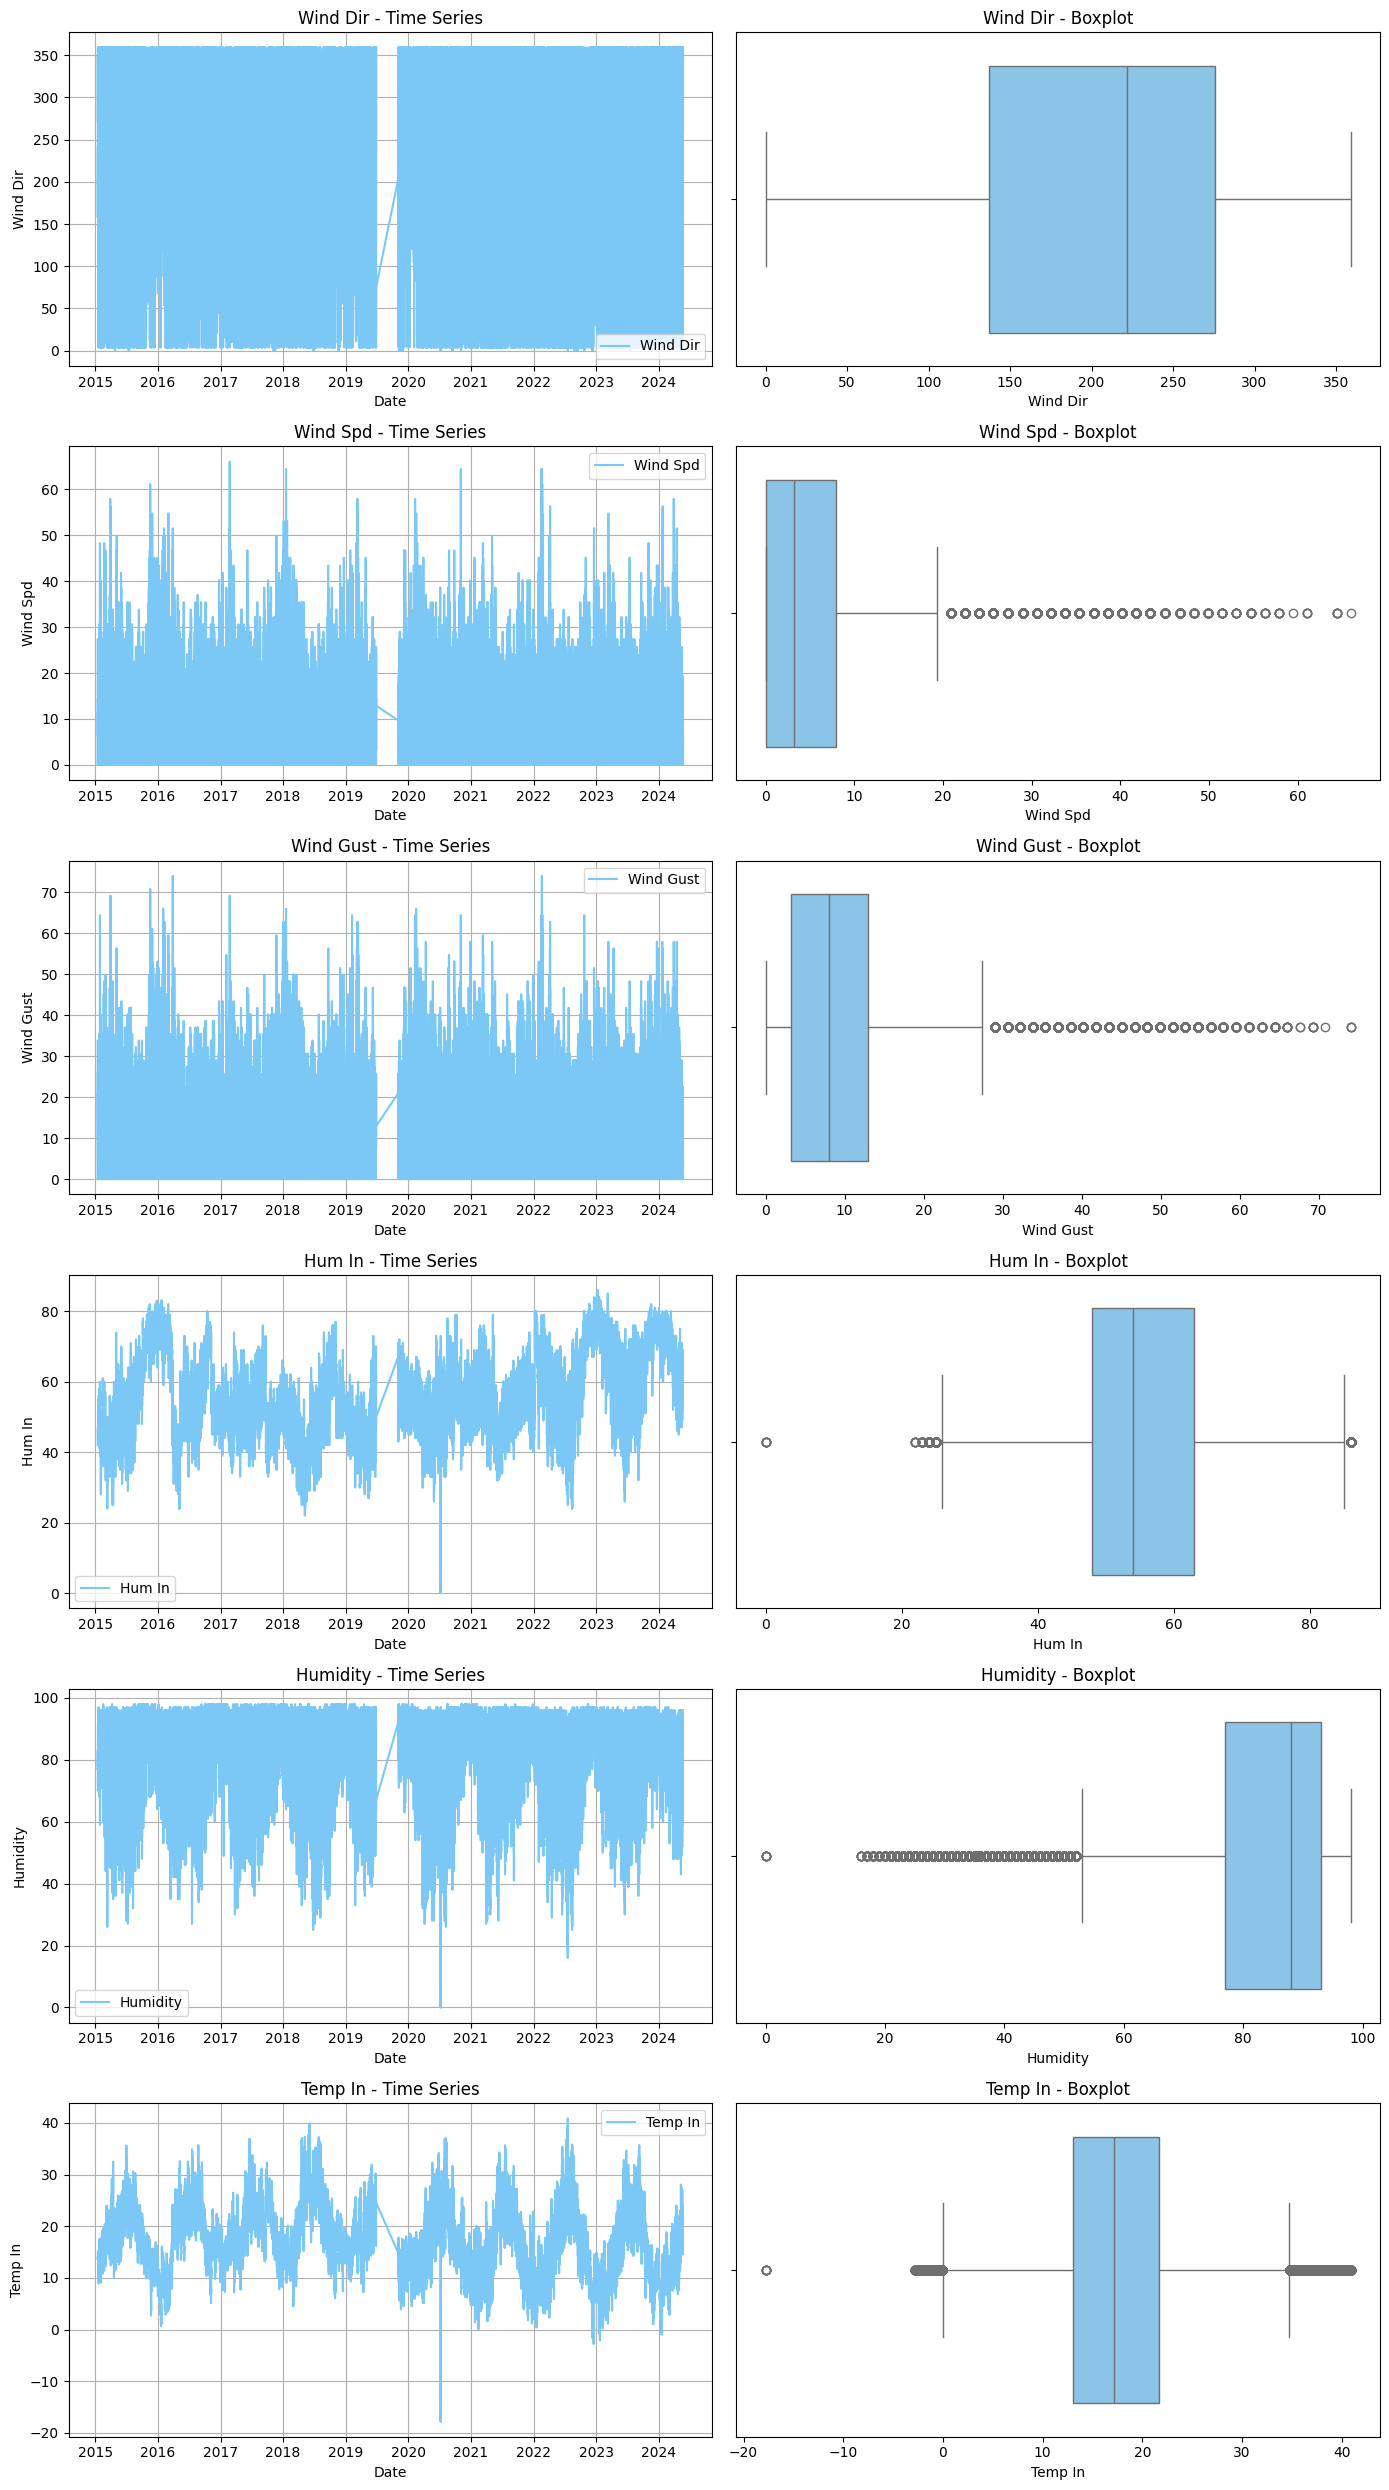

In [ ]:
#First subplot for boxplots and Time Series of each variable
variables = ['Wind Dir', 'Wind Spd', 'Wind Gust', 'Hum In', 'Humidity', 'Temp In']
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(14,25), sharex=False)

for i, var in enumerate(variables):
    # Time Series Plot
    axes[i, 0].plot(met_data_copy.index, met_data_copy[var], label=var, color='xkcd:lightblue')
    axes[i, 0].set_title(f'{var} - Time Series')
    axes[i, 0].set_ylabel(var)
    axes[i, 0].set_xlabel('Date')
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    # Boxplot
    sns.boxplot(x=met_data_copy[var], ax=axes[i, 1], color='xkcd:lightblue')
    axes[i, 1].set_title(f'{var} - Boxplot')
    axes[i, 1].set_xlabel(var)

plt.tight_layout()
plt.show()

<ipython-input-19-a1e2edebdd64>:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


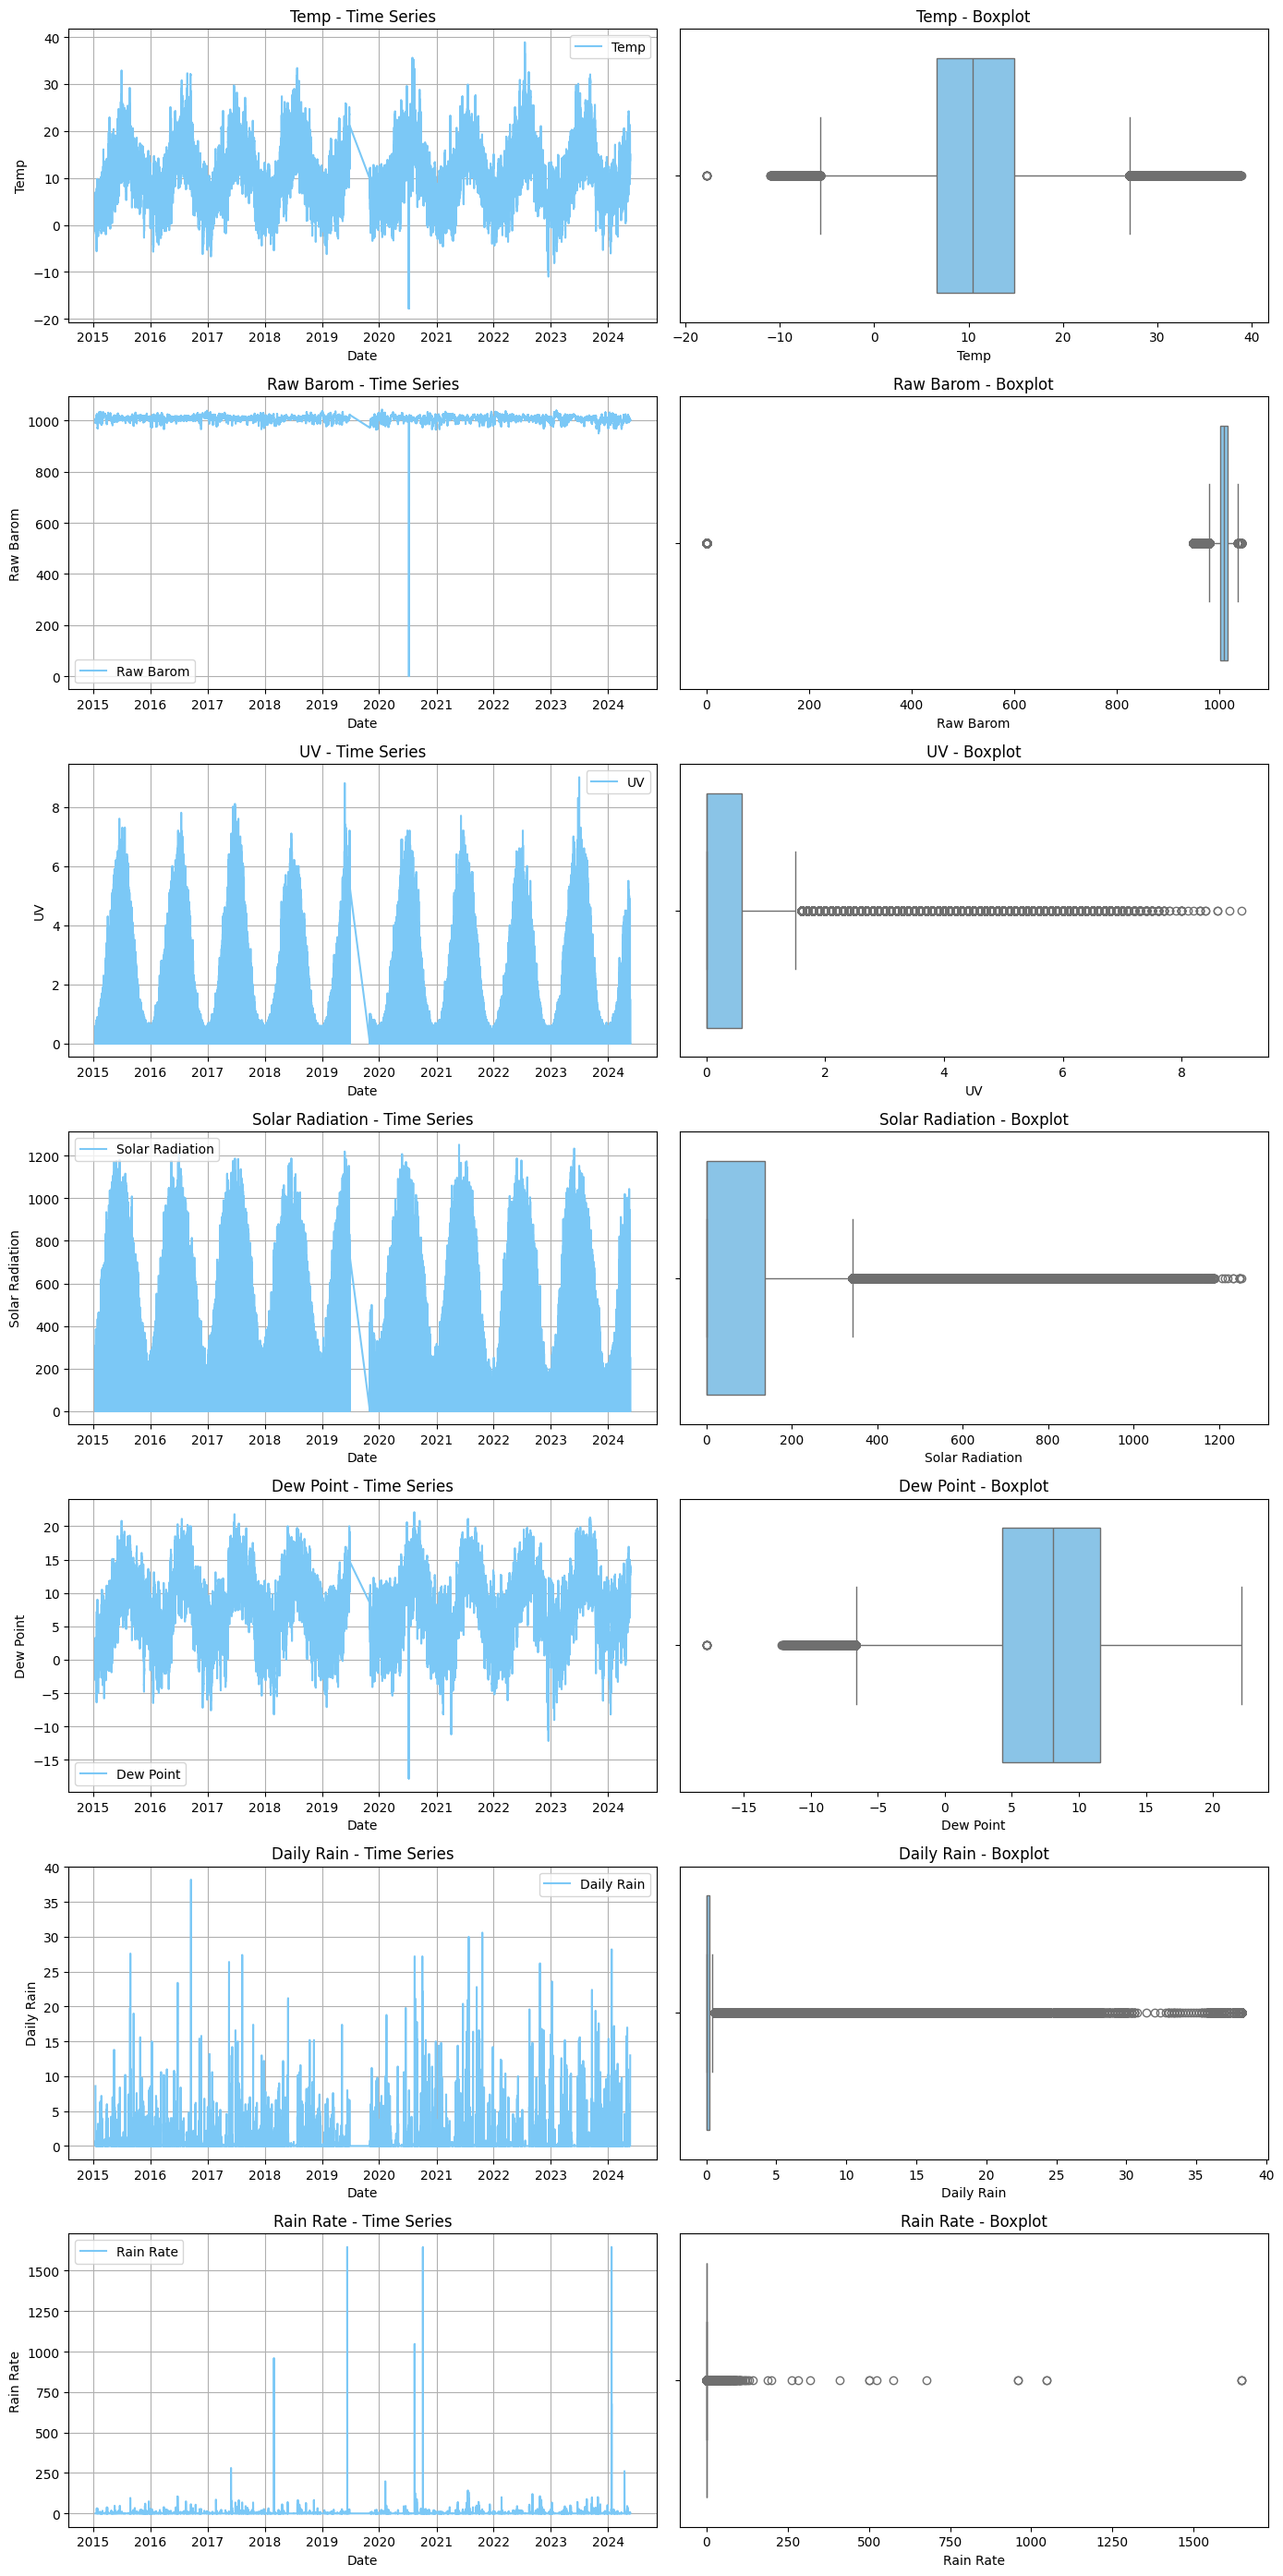

In [ ]:
#Second subplot
variables = ['Temp', 'Raw Barom', 'UV', 'Solar Radiation', 'Dew Point', 'Daily Rain', 'Rain Rate']
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(14,28), sharex=False)

for i, var in enumerate(variables):
    axes[i, 0].plot(met_data_copy.index, met_data_copy[var], label=var, color='xkcd:lightblue')
    axes[i, 0].set_title(f'{var} - Time Series')
    axes[i, 0].set_ylabel(var)
    axes[i, 0].set_xlabel('Date')
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    sns.boxplot(x=met_data_copy[var], ax=axes[i, 1], color='xkcd:lightblue')
    axes[i, 1].set_title(f'{var} - Boxplot')
    axes[i, 1].set_xlabel(var)

plt.tight_layout()
plt.show()

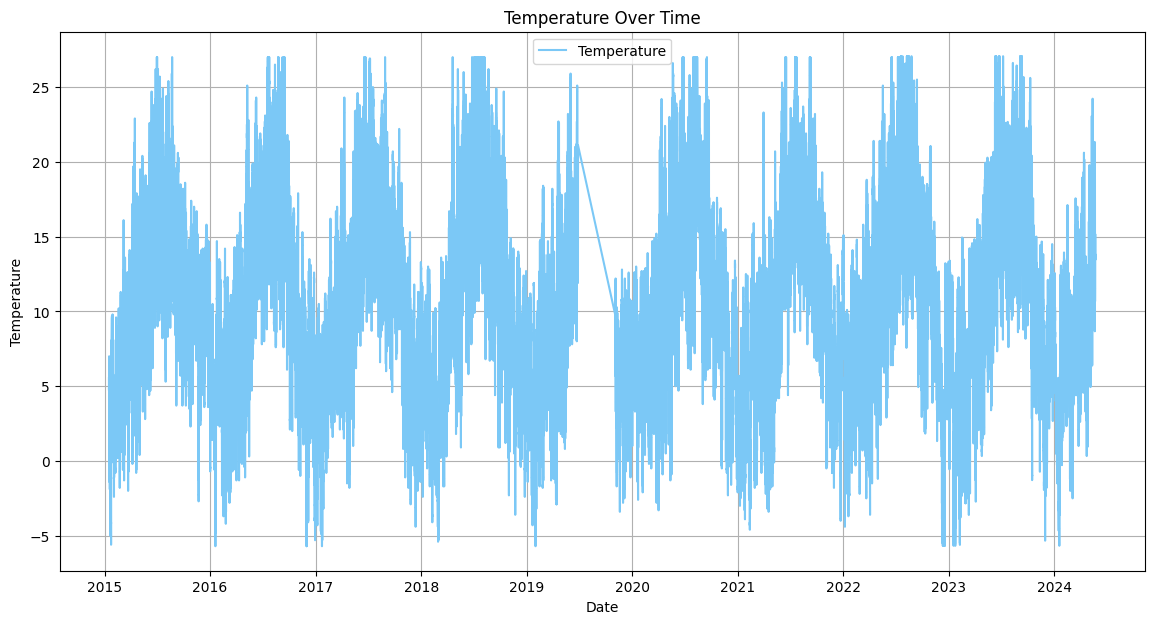

In [ ]:
#Attempting to use the interquartile range method to remove outliers in the data
q1_temp = met_data_copy['Temp'].quantile(0.25)
q3_temp = met_data_copy['Temp'].quantile(0.75)
iqr_temp = q3_temp - q1_temp

upper_limit_temp = q3_temp + 1.5 * iqr_temp
lower_limit_temp = q1_temp - 1.5 * iqr_temp
met_data_temp = met_data_copy[(met_data_copy['Temp'] > lower_limit_temp) & (met_data_copy['Temp'] < upper_limit_temp)]

plt.figure(figsize=(14, 7))
plt.plot(met_data_temp.index, met_data_temp['Temp'], label='Temperature', color='xkcd:lightblue')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Inspecting all upper and lower outliers for Temperature
temp_outliers = met_data_copy[(met_data_copy['Temp'] < -10) | (met_data_copy['Temp'] > 30)]
temp_outliers

Wind Dir  Wind Spd  Wind Gust  Hum In  Humidity  Temp In  \
2015-07-01 09:45:00     122.0       8.0       16.1    47.0      47.0    29.30   
2015-07-01 09:46:00     123.0       9.7       16.1    47.0      46.0    29.30   
2015-07-01 09:47:00     109.0      12.9       16.1    47.0      46.0    29.30   
2015-07-01 09:48:00     137.0       6.4       12.9    47.0      47.0    29.40   
2015-07-01 09:49:00     126.0      11.3       12.9    47.0      47.0    29.40   
...                       ...       ...        ...     ...       ...      ...   
2023-09-10 13:32:00     222.0      12.9       17.7    51.0      56.0    31.78   
2023-09-10 13:33:00     260.0      12.9       17.7    51.0      56.0    31.78   
2023-09-10 13:34:00     253.0       4.8       14.5    51.0      56.0    31.78   
2023-09-10 13:35:00     244.0       3.2       14.5    51.0      57.0    31.78   
2023-09-10 13:36:00     241.0       8.0       17.7    51.0      58.0    31.78   

                      Temp  Raw Barom   UV  Solar Radiation  Dew Point  \
2015-07-01 09:45:00  30.10    1005.00  4.3            684.0      17.50   
2015-07-01 09:46:00  30.10    1005.00  4.3            680.0      17.20   
2015-07-01 09:47:00  30.10    1005.00  4.3            684.0      17.20   
2015-07-01 09:48:00  30.10    1005.00  4.3            686.0      17.60   
2015-07-01 09:49:00  30.20    1004.90  4.3            686.0      17.60   
...                    ...        ...  ...              ...        ...   
2023-09-10 13:32:00  30.83    1006.45  2.3            462.0      21.05   
2023-09-10 13:33:00  30.67    1006.45  2.4            441.0      20.89   
2023-09-10 13:34:00  30.50    1006.42  2.4            425.0      20.74   
2023-09-10 13:35:00  30.28    1006.42  2.4            468.0      20.82   
2023-09-10 13:36:00  30.17    1006.38  2.3            448.0      21.00   

                     Daily Rain  Rain Rate  
2015-07-01 09:45:00         0.0        0.0  
2015-07-01 09:46:00         0.0        0.0  
2015-07-01 09:47:00         0.0        0.0  
2015-07-01 09:48:00         0.0        0.0  
2015-07-01 09:49:00         0.0        0.0  
...                         ...        ...  
2023-09-10 13:32:00         0.0        0.0  
2023-09-10 13:33:00         0.0        0.0  
2023-09-10 13:34:00         0.0        0.0  
2023-09-10 13:35:00         0.0        0.0  
2023-09-10 13:36:00         0.0        0.0  

[8908 rows x 13 columns]

In [ ]:
#Inspecting all upper and lower outliers for Dew Point
dew_outliers = met_data_copy[(met_data_copy['Dew Point'] < -10)]
dew_outliers

Wind Dir  Wind Spd  Wind Gust  Hum In  Humidity  Temp In  \
2020-07-07 20:57:00      0.00      0.00       0.00    0.00      0.00   -17.80   
2020-07-07 20:58:00      0.00      0.00       0.00    0.00      0.00   -17.80   
2020-07-07 20:59:00      0.00      0.00       0.00    0.00      0.00   -17.80   
2020-07-07 21:03:00      0.00      0.00       0.00    0.00      0.00   -17.80   
2020-07-07 21:04:00      0.00      0.00       0.00    0.00      0.00   -17.80   
...                       ...       ...        ...     ...       ...      ...   
2022-12-17 04:40:00    289.00      0.00       0.00   67.00     93.00    -2.78   
2022-12-17 04:42:00    289.00      0.00       0.00   67.00     93.00    -2.78   
2022-12-17 04:53:00    289.00      0.00       0.00   67.00     93.00    -2.78   
2022-12-17 04:58:00    289.00      0.00       0.00   68.00     93.00    -2.78   
2022-12-17 05:00:00    289.00      0.00       0.00   68.00     93.00    -2.78   

                      Temp  Raw Barom   UV  Solar Radiation  Dew Point  \
2020-07-07 20:57:00 -17.80       0.00 0.00             0.00     -17.80   
2020-07-07 20:58:00 -17.80       0.00 0.00             0.00     -17.80   
2020-07-07 20:59:00 -17.80       0.00 0.00             0.00     -17.80   
2020-07-07 21:03:00 -17.80       0.00 0.00             0.00     -17.80   
2020-07-07 21:04:00 -17.80       0.00 0.00             0.00     -17.80   
...                    ...        ...  ...              ...        ...   
2022-12-17 04:40:00  -9.89    1013.96 0.00             0.00     -10.80   
2022-12-17 04:42:00  -9.89    1013.96 0.00             0.00     -10.80   
2022-12-17 04:53:00  -9.50    1013.99 0.00             0.00     -10.42   
2022-12-17 04:58:00  -9.33    1014.06 0.00             0.00     -10.25   
2022-12-17 05:00:00  -9.22    1014.02 0.00             0.00     -10.14   

                     Daily Rain  Rain Rate  
2020-07-07 20:57:00        0.00      -0.20  
2020-07-07 20:58:00        0.00      -0.20  
2020-07-07 20:59:00        0.00      -0.20  
2020-07-07 21:03:00        0.00      -0.20  
2020-07-07 21:04:00        0.00      -0.20  
...                         ...        ...  
2022-12-17 04:40:00        0.00       0.00  
2022-12-17 04:42:00        0.00       0.00  
2022-12-17 04:53:00        0.00       0.00  
2022-12-17 04:58:00        0.00       0.00  
2022-12-17 05:00:00        0.00       0.00  

[442 rows x 13 columns]

In [ ]:
#Inspect outliers for humidity
humidity = met_data_copy[met_data_copy['Humidity']<20]
humidity

Wind Dir  Wind Spd  Wind Gust  Hum In  Humidity  Temp In  \
2020-07-07 20:57:00       0.0       0.0        0.0     0.0       0.0   -17.80   
2020-07-07 20:58:00       0.0       0.0        0.0     0.0       0.0   -17.80   
2020-07-07 20:59:00       0.0       0.0        0.0     0.0       0.0   -17.80   
2020-07-07 21:03:00       0.0       0.0        0.0     0.0       0.0   -17.80   
2020-07-07 21:04:00       0.0       0.0        0.0     0.0       0.0   -17.80   
...                       ...       ...        ...     ...       ...      ...   
2022-07-19 14:44:00     143.0      22.5       27.4    26.0      19.0    39.44   
2022-07-19 14:45:00     131.0      17.7       25.7    26.0      19.0    39.61   
2022-07-19 14:46:00     160.0       9.7       19.3    26.0      19.0    39.61   
2022-07-19 14:47:00     109.0      12.9       19.3    26.0      19.0    39.61   
2022-07-19 14:50:00     145.0      12.9       27.4    26.0      19.0    39.61   

                      Temp  Raw Barom   UV  Solar Radiation  Dew Point  \
2020-07-07 20:57:00 -17.80       0.00  0.0              0.0     -17.80   
2020-07-07 20:58:00 -17.80       0.00  0.0              0.0     -17.80   
2020-07-07 20:59:00 -17.80       0.00  0.0              0.0     -17.80   
2020-07-07 21:03:00 -17.80       0.00  0.0              0.0     -17.80   
2020-07-07 21:04:00 -17.80       0.00  0.0              0.0     -17.80   
...                    ...        ...  ...              ...        ...   
2022-07-19 14:44:00  38.28    1001.91  2.8            613.0      10.62   
2022-07-19 14:45:00  38.17    1001.91  2.8            612.0      10.53   
2022-07-19 14:46:00  38.06    1001.97  2.7            608.0      10.44   
2022-07-19 14:47:00  38.06    1001.94  2.7            608.0      10.44   
2022-07-19 14:50:00  38.00    1001.91  2.7            605.0      10.40   

                     Daily Rain  Rain Rate  
2020-07-07 20:57:00         0.0       -0.2  
2020-07-07 20:58:00         0.0       -0.2  
2020-07-07 20:59:00         0.0       -0.2  
2020-07-07 21:03:00         0.0       -0.2  
2020-07-07 21:04:00         0.0       -0.2  
...                         ...        ...  
2022-07-19 14:44:00         0.0        0.0  
2022-07-19 14:45:00         0.0        0.0  
2022-07-19 14:46:00         0.0        0.0  
2022-07-19 14:47:00         0.0        0.0  
2022-07-19 14:50:00         0.0        0.0  

[142 rows x 13 columns]

In [ ]:
#Inspect outliers for Rain Rate
r = met_data_copy[met_data_copy['Rain Rate']>100]
r

Wind Dir  Wind Spd  Wind Gust  Hum In  Humidity  Temp In  \
2016-06-23 17:38:00     289.0       8.0       11.3    65.0      94.0    25.50   
2017-05-30 09:10:00     218.0       8.0        8.0    59.0      88.0    21.80   
2018-02-28 13:49:00      93.0      22.5       29.0    38.0      68.0     9.10   
2019-06-11 11:34:00     343.0       6.4       11.3    66.0      88.0    20.00   
2020-02-09 15:32:00     238.0      19.3       48.3    50.0      92.0    17.50   
2020-08-14 08:17:00     337.0       1.6        3.2    69.0      97.0    20.70   
2020-08-14 08:18:00     337.0       4.8        6.4    69.0      97.0    20.70   
2020-08-14 08:19:00     337.0       0.0        4.8    69.0      97.0    20.70   
2020-08-14 08:20:00     337.0       6.4        6.4    69.0      97.0    20.70   
2020-08-17 16:20:00     241.0      17.7       30.6    67.0      84.0    25.40   
2020-08-17 16:21:00     262.0       1.6       24.1    67.0      84.0    25.40   
2020-08-17 16:23:00     193.0       9.7        9.7    67.0      85.0    25.40   
2020-08-17 16:24:00     175.0       6.4        9.7    67.0      86.0    25.40   
2020-10-06 10:28:00     255.0      11.3       17.7    74.0      85.0    16.30   
2021-07-20 16:25:00      79.0       4.8       16.1    42.0      80.0    33.80   
2021-07-25 15:48:00     120.0       6.4        8.0    48.0      84.0    26.70   
2022-02-20 18:19:00     284.0      61.1       61.1    76.0      94.0    13.30   
2022-09-05 22:26:00     266.0       4.8       11.3    61.0      88.0    22.94   
2022-09-05 22:27:00     214.0       4.8        6.4    61.0      88.0    22.94   
2022-10-23 16:46:00     225.0      17.7       30.6    74.0      88.0    19.94   
2023-10-28 23:13:00     182.0      11.3       12.9    73.0      96.0    15.50   
2024-01-24 01:06:00     228.0      37.0       56.3    76.0      74.0    13.89   
2024-01-24 01:15:00     243.0      24.1       41.8    75.0      73.0    13.78   
2024-01-24 01:22:00     287.0      30.6       33.8    75.0      73.0    13.78   
2024-01-24 01:26:00     227.0      19.3       41.8    75.0      73.0    13.72   
2024-01-24 02:27:00     237.0      27.4       33.8    74.0      75.0    13.72   
2024-01-24 02:49:00     199.0      22.5       35.4    73.0      75.0    13.61   
2024-01-24 02:52:00     303.0      17.7       41.8    73.0      75.0    13.61   
2024-01-24 08:00:00     233.0      27.4       38.6    71.0      79.0    12.50   
2024-04-15 09:05:00     254.0      11.3       19.3    62.0      89.0    12.89   

                      Temp  Raw Barom   UV  Solar Radiation  Dew Point  \
2016-06-23 17:38:00  18.50    1007.90  0.0              9.0      17.50   
2017-05-30 09:10:00  15.90    1007.80  1.9            236.0      13.90   
2018-02-28 13:49:00  -1.80    1010.50  1.1            545.0      -7.00   
2019-06-11 11:34:00  14.80    1005.20  1.7            239.0      12.80   
2020-02-09 15:32:00  12.70     978.80  0.0              5.0      11.40   
2020-08-14 08:17:00  16.20    1006.80  0.0             77.0      15.70   
2020-08-14 08:18:00  16.20    1006.80  0.5             67.0      15.70   
2020-08-14 08:19:00  16.20    1006.80  0.5             69.0      15.70   
2020-08-14 08:20:00  16.20    1006.90  0.5             70.0      15.70   
2020-08-17 16:20:00  19.00    1000.50  0.0             26.0      16.20   
2020-08-17 16:21:00  18.70    1000.70  0.0             32.0      15.90   
2020-08-17 16:23:00  18.30    1000.50  0.0             76.0      15.80   
2020-08-17 16:24:00  18.20    1000.40  0.0            102.0      15.80   
2020-10-06 10:28:00  13.50     990.10  0.7             81.0      11.00   
2021-07-20 16:25:00  22.60    1013.10  0.0             39.0      19.00   
2021-07-25 15:48:00  18.80    1000.90  0.0              5.0      16.00   
2022-02-20 18:19:00  10.90     985.60  0.0              0.0      10.00   
2022-09-05 22:26:00  18.78    1007.73  0.0              0.0      16.75   
2022-09-05 22:27:00  18.72    1007.59  0.0              0.0      16.70   
2022-10-23 16:46:00  13.83   

In [ ]:
#Inspect outliers for daily rain
rain = met_data_copy[met_data_copy['Daily Rain']>30]
rain

Wind Dir  Wind Spd  Wind Gust  Hum In  Humidity  Temp In  \
2016-09-16 06:28:00    284.00      1.60       4.80   59.00     96.00    24.20   
2016-09-16 06:29:00    284.00      6.40       8.00   59.00     96.00    24.20   
2016-09-16 06:30:00    312.00      8.00       9.70   59.00     96.00    24.20   
2016-09-16 06:31:00    285.00     12.90      12.90   59.00     96.00    24.20   
2016-09-16 06:32:00    282.00      6.40      12.90   59.00     96.00    24.20   
...                       ...       ...        ...     ...       ...      ...   
2021-10-20 23:56:00     71.00      4.80      20.90   51.00     94.00    16.60   
2021-10-20 23:57:00    263.00      6.40      16.10   52.00     94.00    16.60   
2021-10-20 23:58:00    294.00      8.00      12.90   53.00     94.00    16.70   
2021-10-20 23:58:00    337.00      9.70      19.30   53.00     94.00    16.70   
2021-10-21 00:00:00    287.00     12.90      19.30   53.00     94.00    16.70   

                     Temp  Raw Barom   UV  Solar Radiation  Dew Point  \
2016-09-16 06:28:00 16.30    1003.50 0.00             0.00      15.70   
2016-09-16 06:29:00 16.30    1003.60 0.00             0.00      15.70   
2016-09-16 06:30:00 16.30    1003.60 0.00             0.00      15.70   
2016-09-16 06:31:00 16.30    1003.60 0.00             0.00      15.60   
2016-09-16 06:32:00 16.30    1003.60 0.00             0.00      15.60   
...                   ...        ...  ...              ...        ...   
2021-10-20 23:56:00  8.40     984.10 0.00             0.00       7.50   
2021-10-20 23:57:00  8.40     984.10 0.00             0.00       7.50   
2021-10-20 23:58:00  8.40     984.10 0.00             0.00       7.50   
2021-10-20 23:58:00  8.40     984.10 0.00             0.00       7.50   
2021-10-21 00:00:00  8.40     984.10 0.00             0.00       7.50   

                     Daily Rain  Rain Rate  
2016-09-16 06:28:00       30.20      17.60  
2016-09-16 06:29:00       30.40      17.20  
2016-09-16 06:30:00       30.80      34.00  
2016-09-16 06:31:00       31.40      30.40  
2016-09-16 06:32:00       32.00      34.40  
...                         ...        ...  
2021-10-20 23:56:00       30.60       2.40  
2021-10-20 23:57:00       30.60       2.40  
2021-10-20 23:58:00       30.60       2.40  
2021-10-20 23:58:00       30.60       2.40  
2021-10-21 00:00:00       30.60       2.40  

[1066 rows x 13 columns]

In [11]:
#Remove the outlier datapoints
met_data_clean = met_data_copy[
    (met_data_copy['Temp'] != -17.8) &
    (met_data_copy['Dew Point'] != -17.8) &
    (met_data_copy['Humidity'] != 0) &
    (met_data_copy['Raw Barom'] != 0) &
    (met_data_copy['Rain Rate'] <= 100)
]

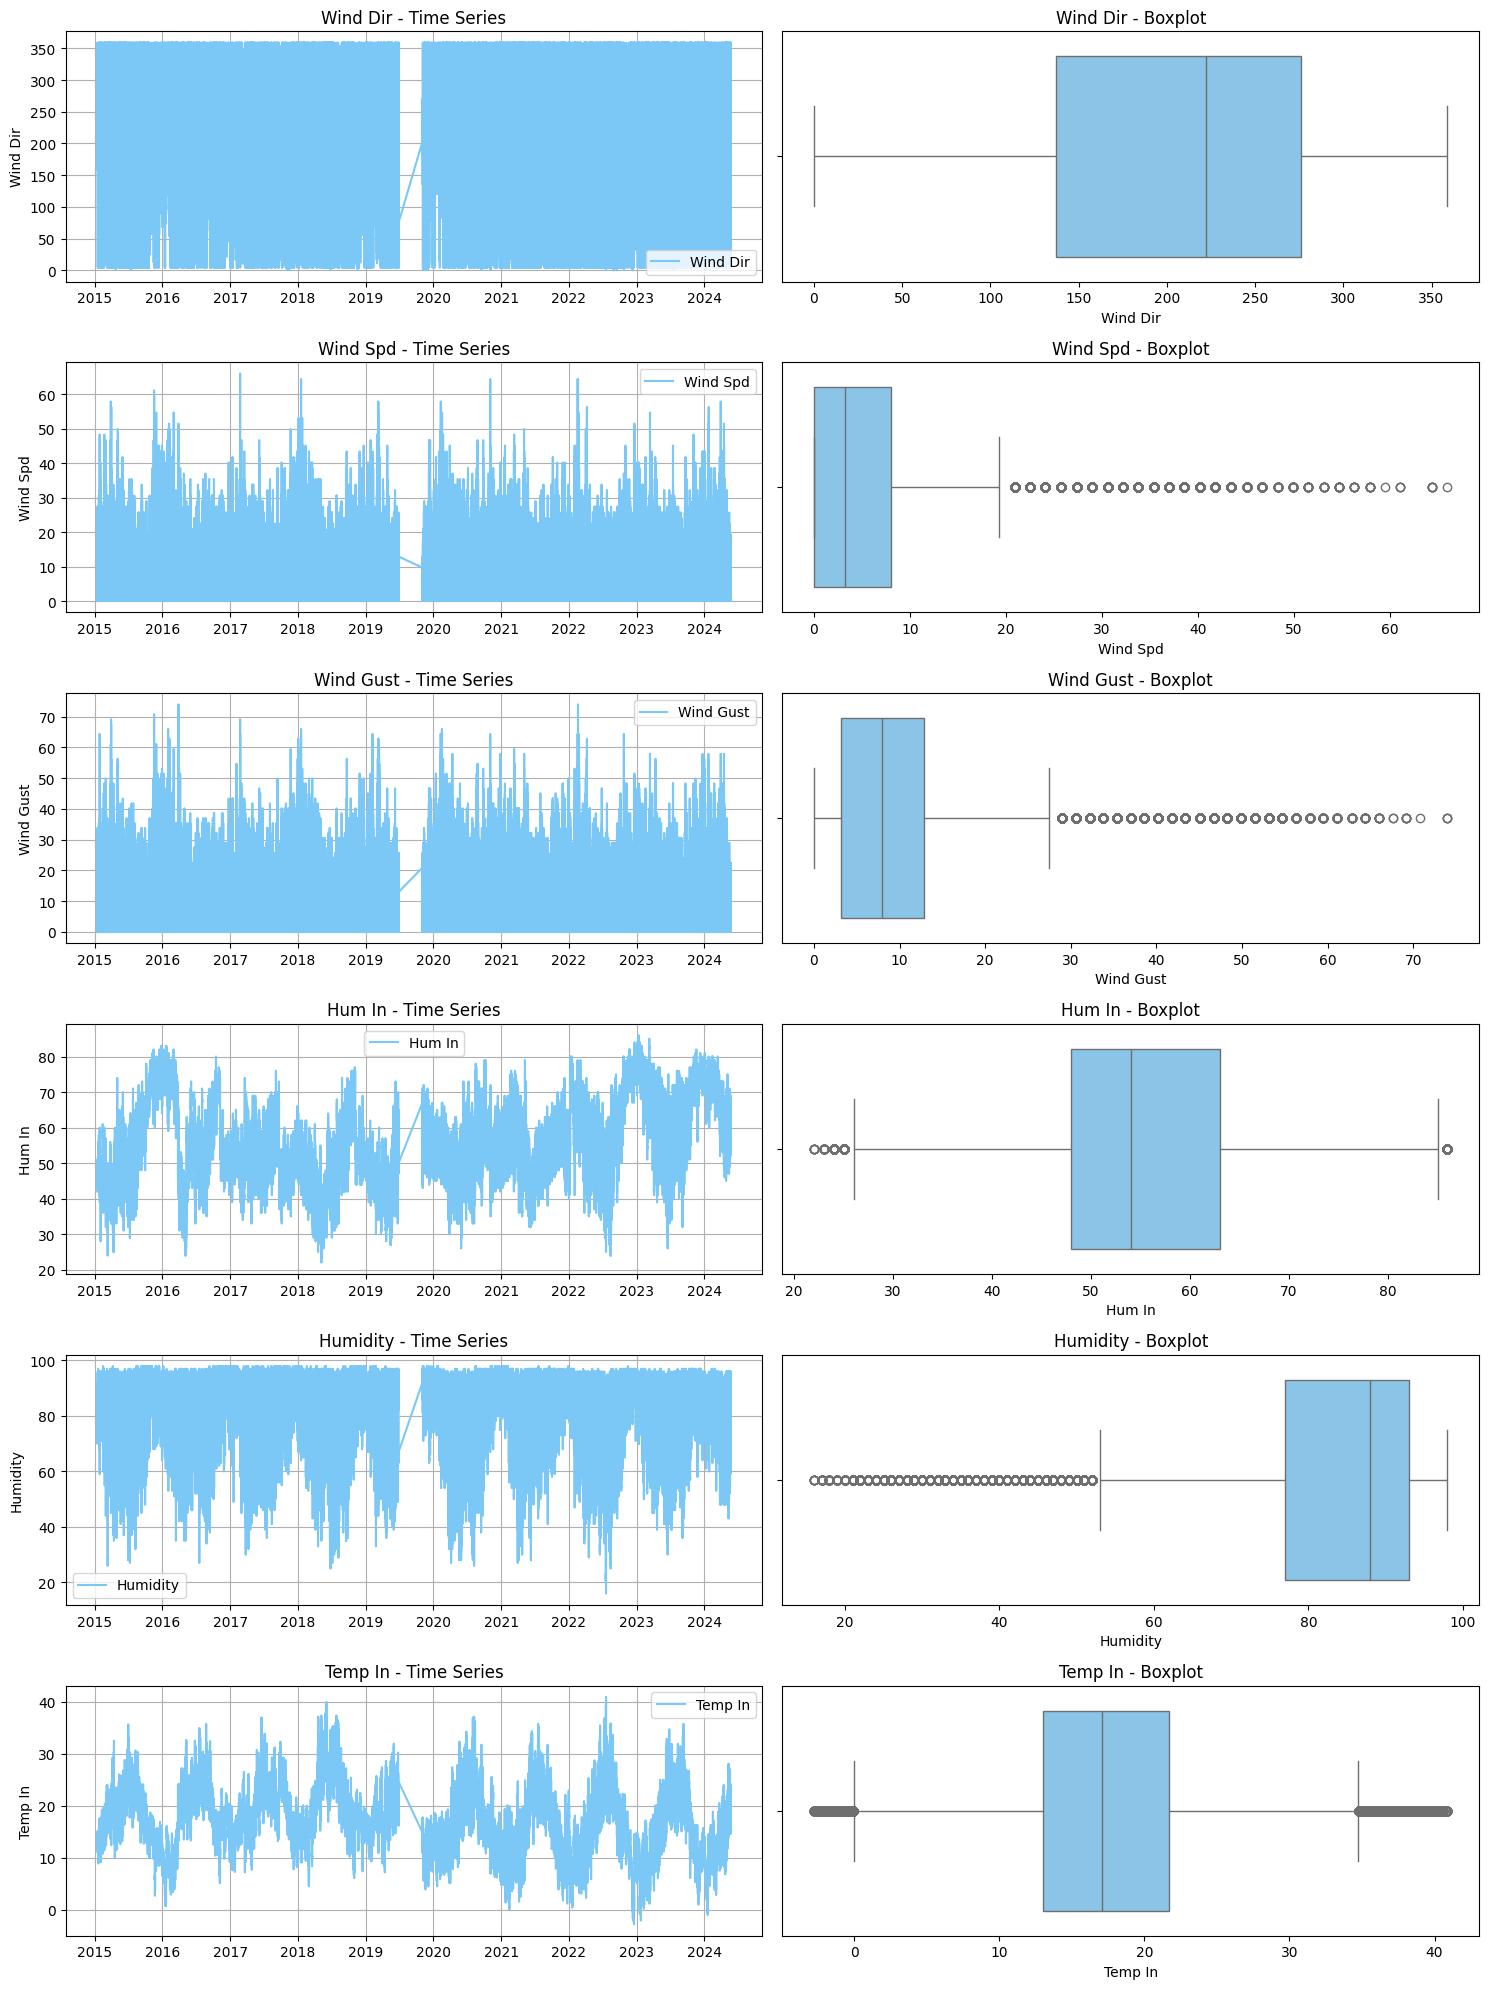

In [ ]:
#Plot data after removing outliers
variables = ['Wind Dir', 'Wind Spd', 'Wind Gust', 'Hum In', 'Humidity', 'Temp In']
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 20), sharex=False)

for i, var in enumerate(variables):
    axes[i, 0].plot(met_data_clean.index, met_data_clean[var], label=var, color='xkcd:lightblue')
    axes[i, 0].set_title(f'{var} - Time Series')
    axes[i, 0].set_ylabel(var)
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    sns.boxplot(x=met_data_clean[var], ax=axes[i, 1], color='xkcd:lightblue')
    axes[i, 1].set_title(f'{var} - Boxplot')
    axes[i, 1].set_xlabel(var)

plt.tight_layout()
plt.show()

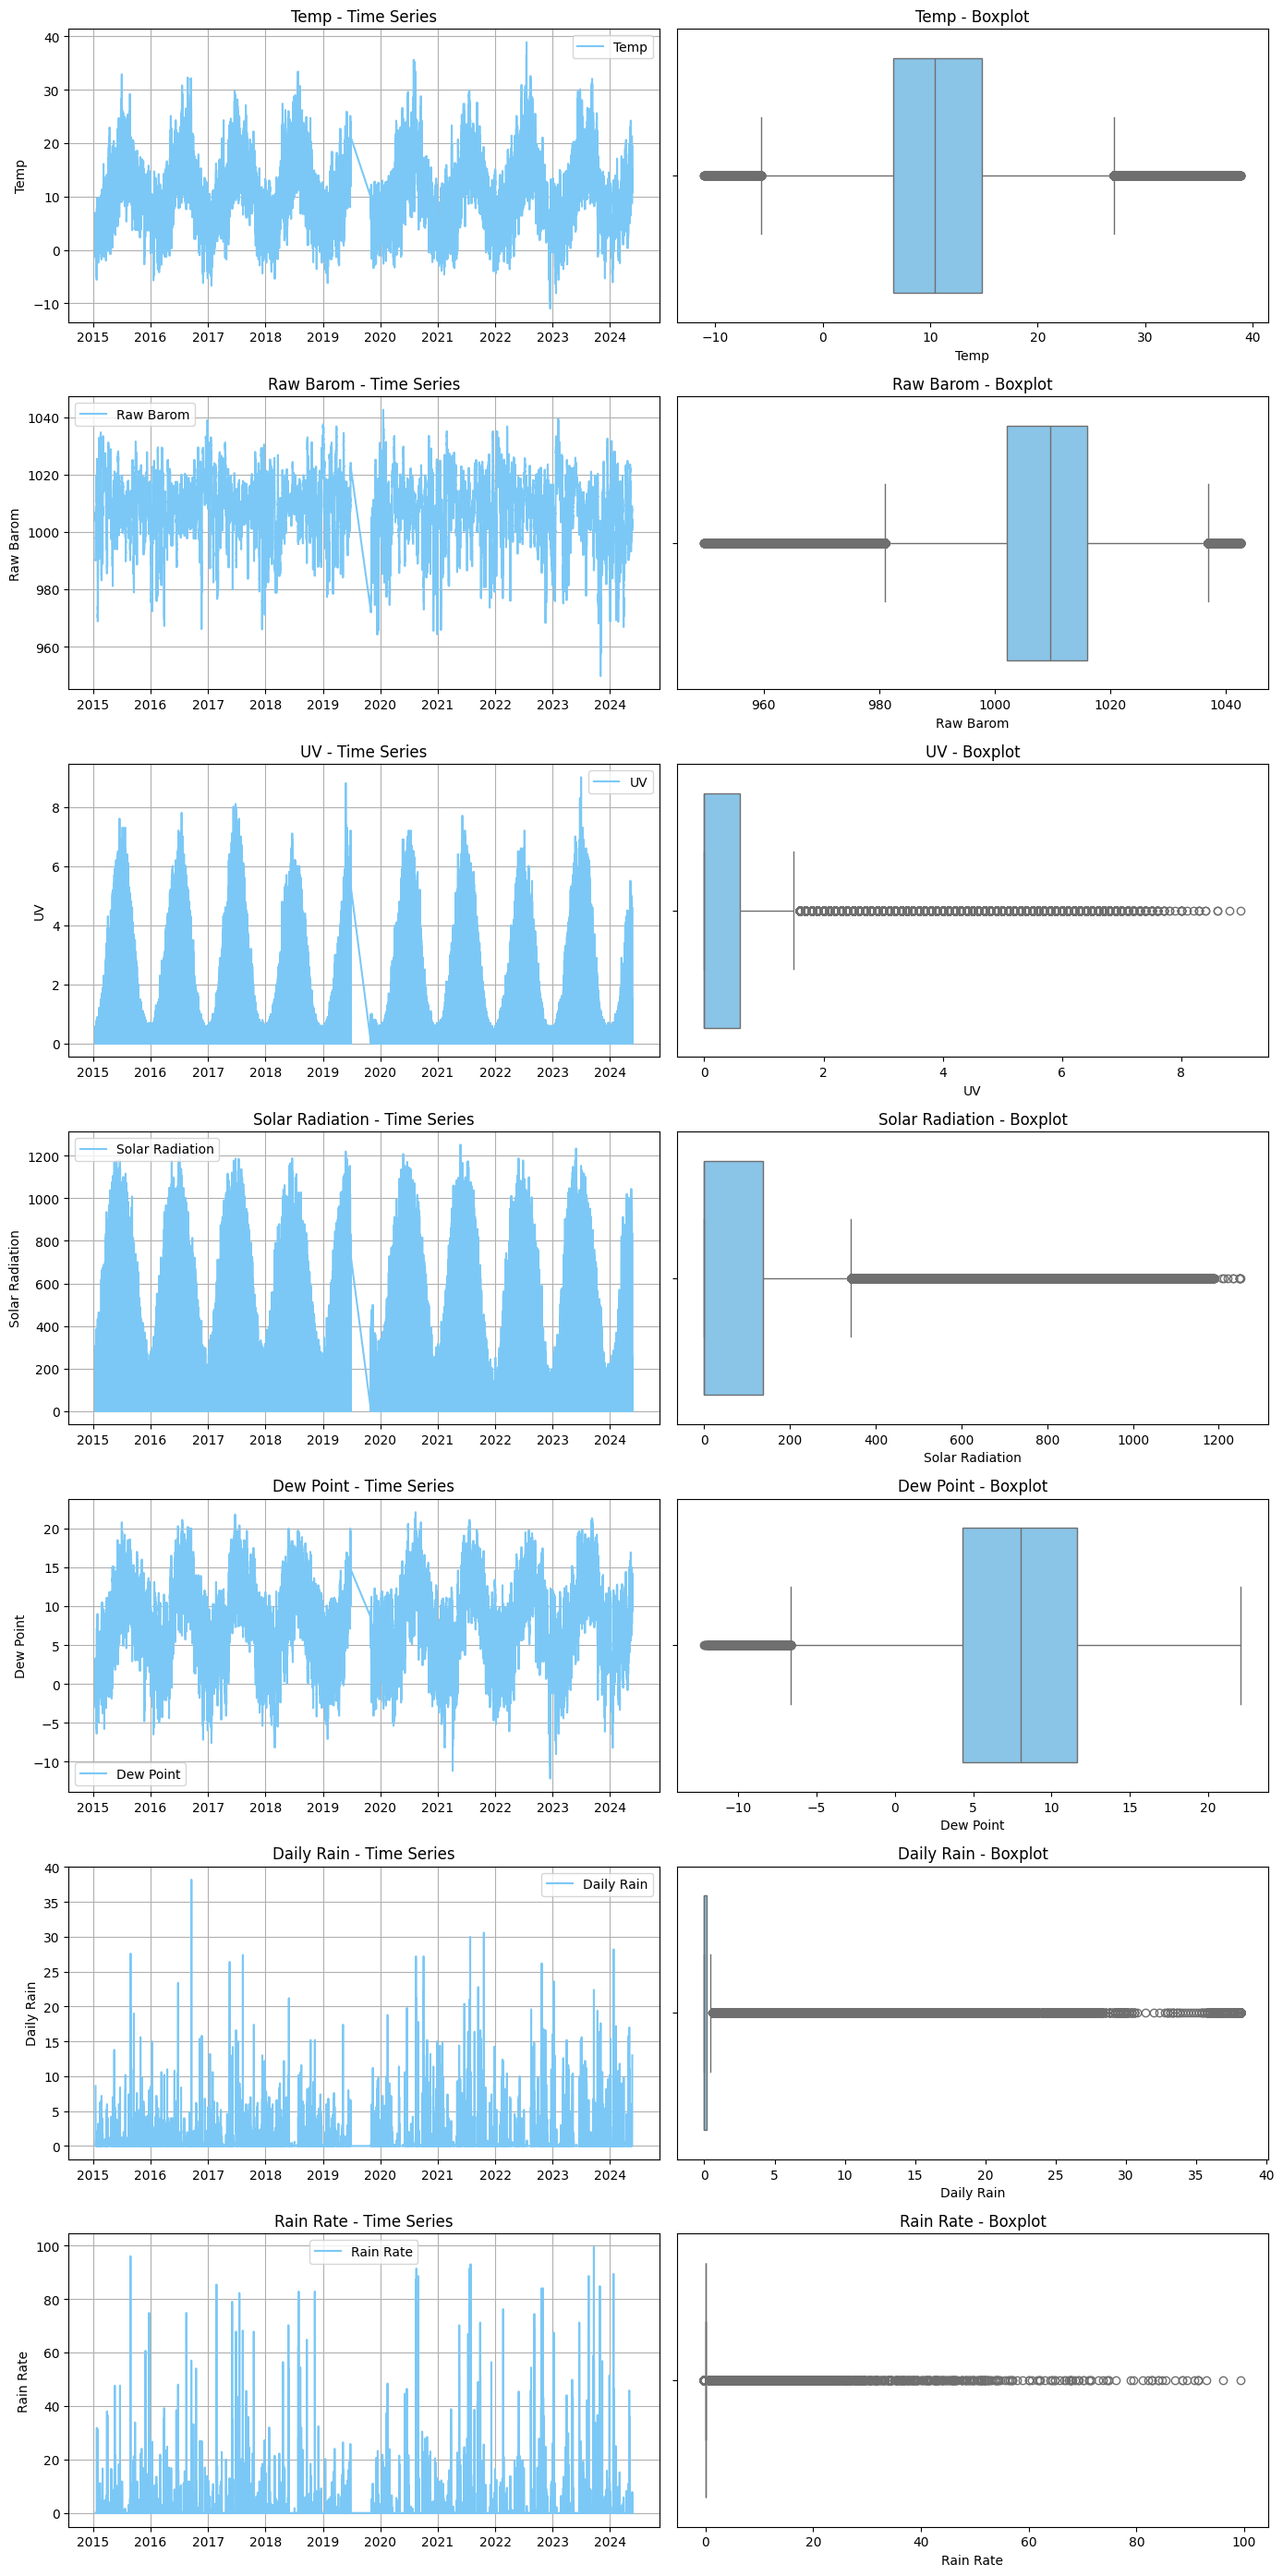

In [ ]:
#Second subplot
variables = ['Temp', 'Raw Barom', 'UV', 'Solar Radiation', 'Dew Point', 'Daily Rain', 'Rain Rate']
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(14,28), sharex=False)

for i, var in enumerate(variables):
    axes[i, 0].plot(met_data_clean.index, met_data_clean[var], label=var, color='xkcd:lightblue')
    axes[i, 0].set_title(f'{var} - Time Series')
    axes[i, 0].set_ylabel(var)
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    sns.boxplot(x=met_data_clean[var], ax=axes[i, 1], color='xkcd:lightblue')
    axes[i, 1].set_title(f'{var} - Boxplot')
    axes[i, 1].set_xlabel(var)

plt.tight_layout()
plt.show()

In [12]:
#Ensure that there are no missing values in the daily average data
daily_data_clean = met_data_clean.resample('D').agg({
    'Wind Dir': 'mean',
    'Wind Spd': 'mean',
    'Wind Gust': 'mean',
    'Hum In': 'mean',
    'Humidity': 'mean',
    'Temp In': 'mean',
    'Temp': 'mean',
    'Raw Barom': 'mean',
    'UV': 'mean',
    'Solar Radiation': 'mean',
    'Dew Point': 'mean',
    'Daily Rain': 'last',
    'Rain Rate': 'mean'
})
daily_data_clean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3414 entries, 2015-01-16 to 2024-05-21
Freq: D
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Wind Dir         3283 non-null   float64
 1   Wind Spd         3283 non-null   float64
 2   Wind Gust        3283 non-null   float64
 3   Hum In           3283 non-null   float64
 4   Humidity         3283 non-null   float64
 5   Temp In          3283 non-null   float64
 6   Temp             3283 non-null   float64
 7   Raw Barom        3283 non-null   float64
 8   UV               3283 non-null   float64
 9   Solar Radiation  3283 non-null   float64
 10  Dew Point        3283 non-null   float64
 11  Daily Rain       3283 non-null   float64
 12  Rain Rate        3283 non-null   float64
dtypes: float64(13)
memory usage: 373.4 KB


In [13]:
#Replace missing values with average of the other corresponding days in the dataset
daily_data_clean['DayOfYear'] = daily_data_clean.index.dayofyear
averages = daily_data_clean.groupby('DayOfYear').mean()

daily_data_clean = daily_data_clean.apply(lambda row: fill_missing(row, averages), axis=1)
daily_data_clean.drop(columns=['DayOfYear'], inplace=True)

## **Time Series Analysis**

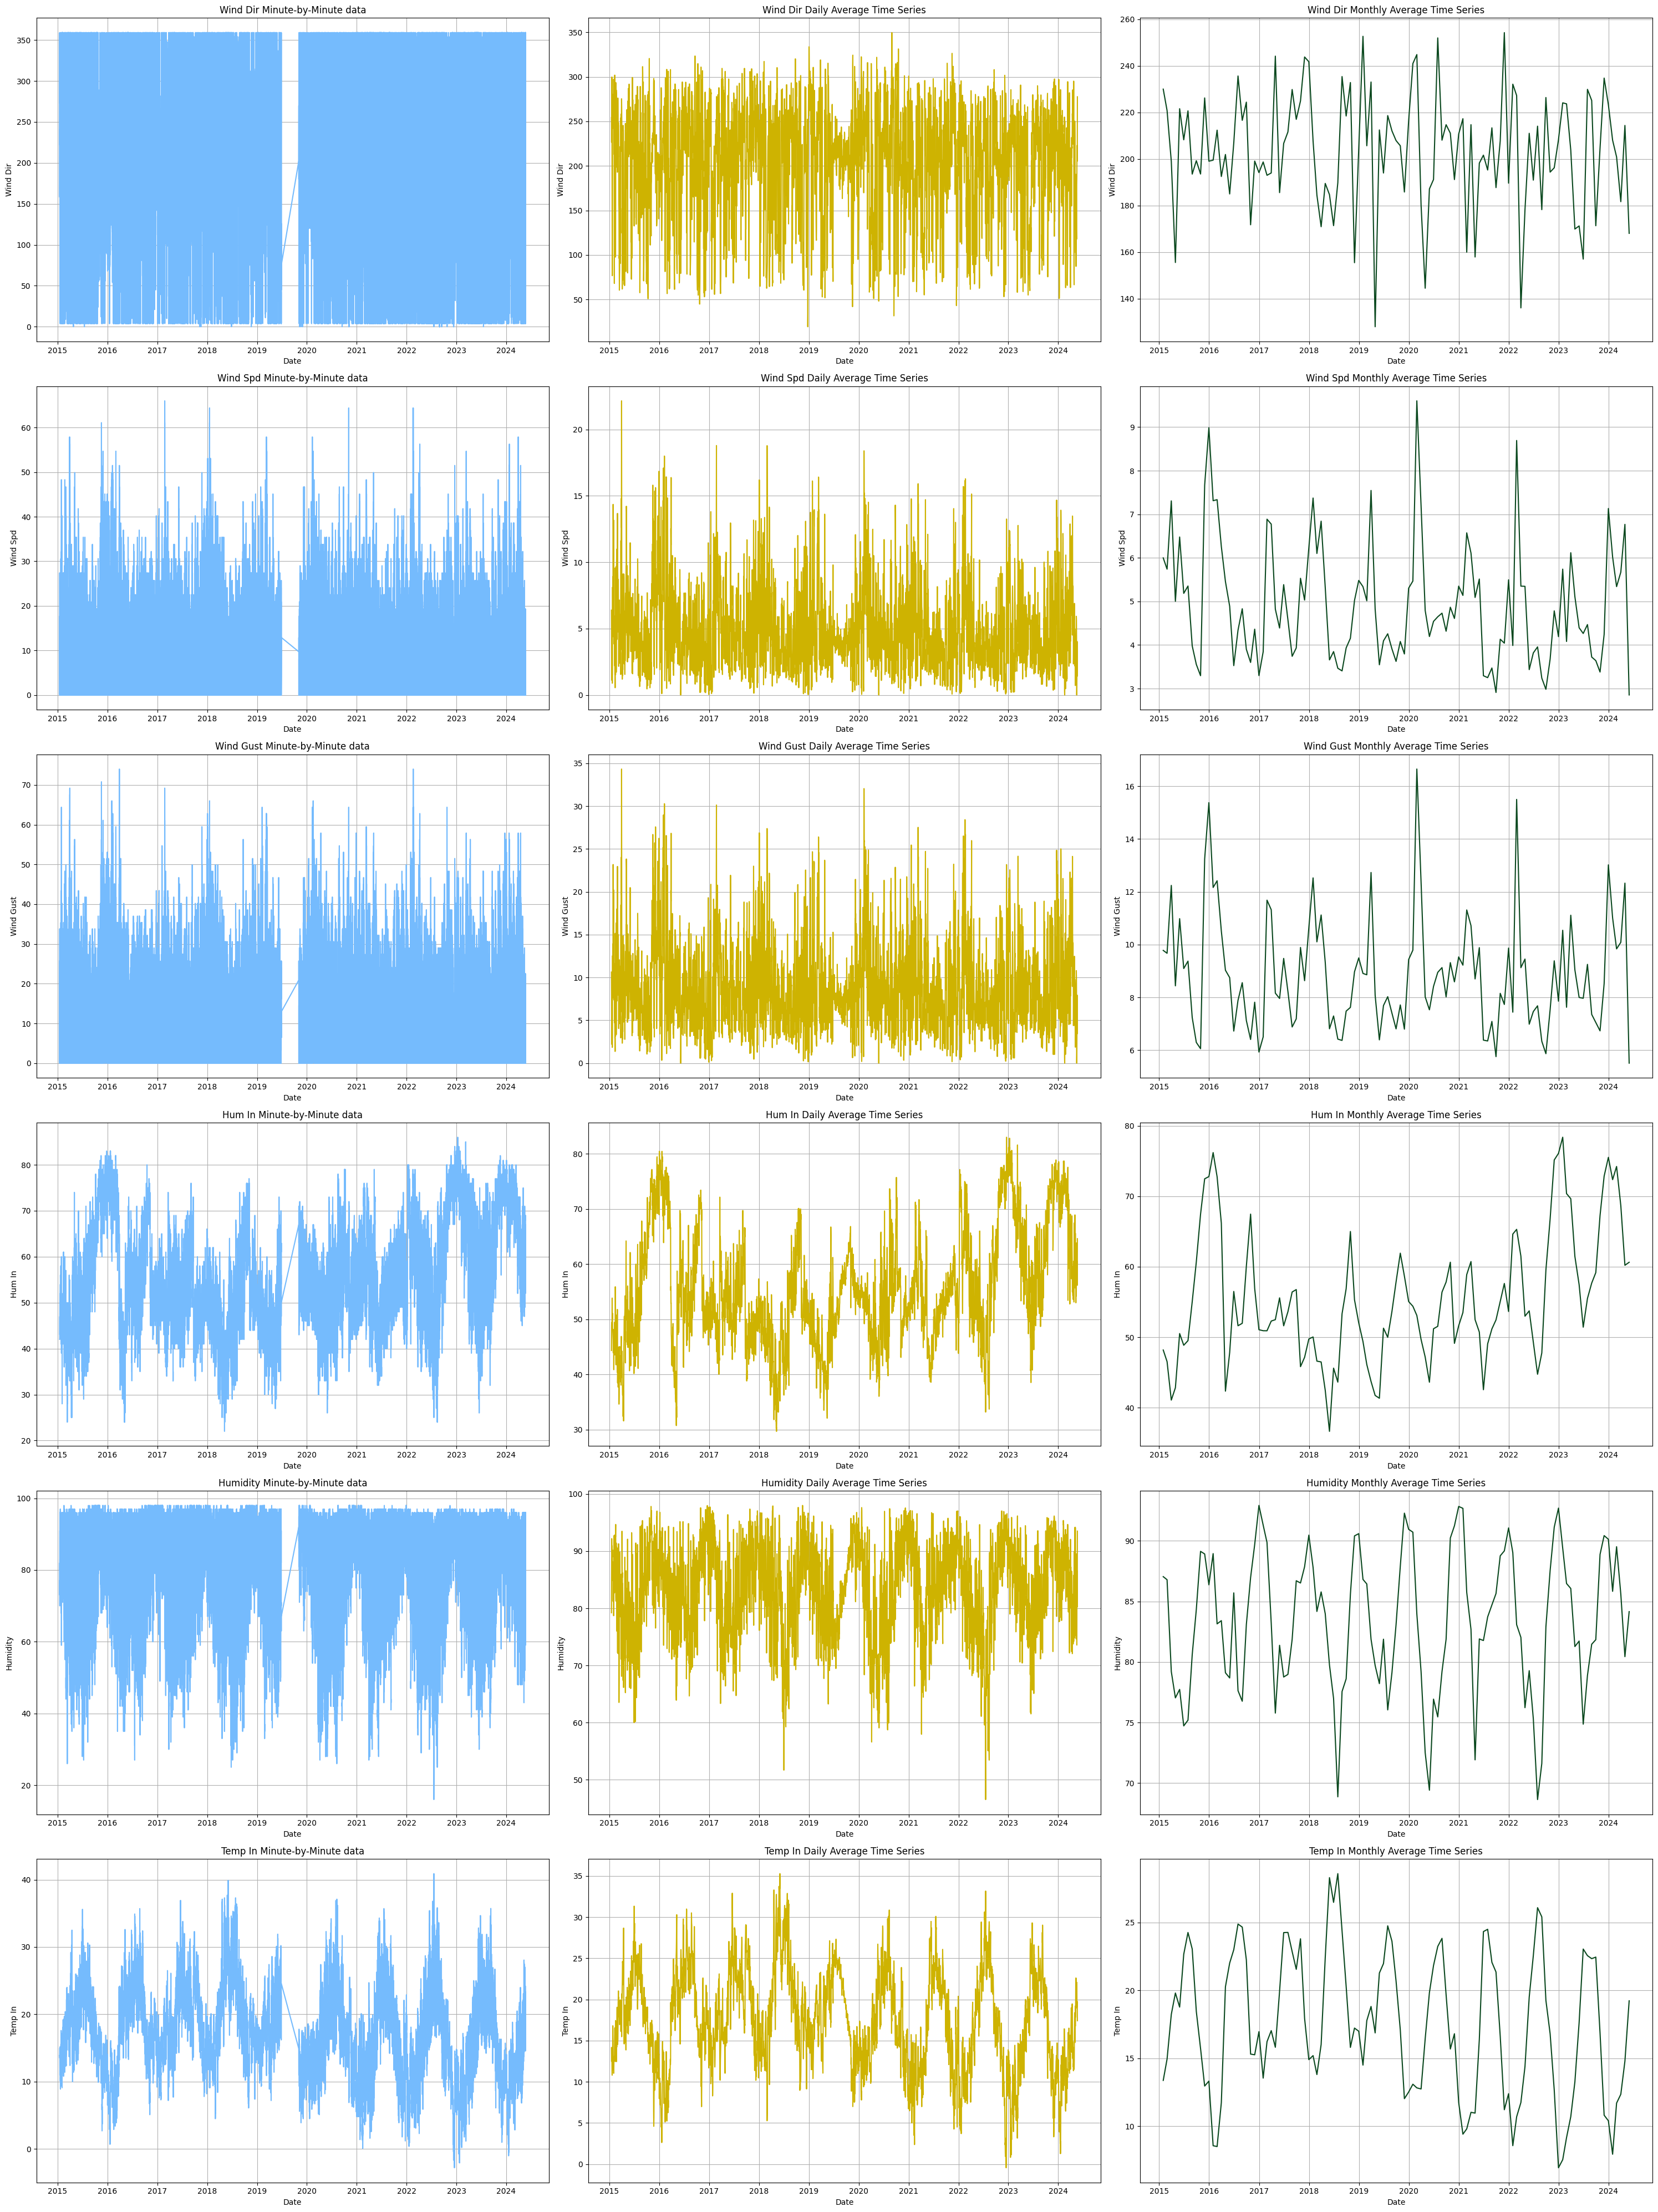

In [ ]:
def plot_time_series(data, variables):
    num_rows = len(variables)
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(30, 40))

    for i, var in enumerate(variables):

        # Plot the original time series data
        axes[i, 0].plot(data.index, data[var], color='xkcd:sky blue')
        axes[i, 0].set_title(f'{var} Minute-by-Minute data')
        axes[i, 0].set_xlabel('Date')
        axes[i, 0].set_ylabel(var)
        axes[i, 0].grid(True)

        #daily average
        daily_data = data.resample('D').mean()
        daily_data['DayOfYear'] = daily_data.index.dayofyear
        averages = daily_data.groupby('DayOfYear').mean()

        daily_data = daily_data.apply(lambda row: fill_missing(row, averages), axis=1)
        daily_data.drop(columns=['DayOfYear'], inplace=True)

        axes[i, 1].plot(daily_data.index, daily_data[var], color='xkcd:mustard')
        axes[i, 1].set_title(f'{var} Daily Average Time Series')
        axes[i, 1].set_xlabel('Date')
        axes[i, 1].set_ylabel(var)
        axes[i, 1].grid(True)

        #monthly average
        monthly_avg = daily_data.resample('M').mean()
        axes[i, 2].plot(monthly_avg.index, monthly_avg[var], color='xkcd:pine green')
        axes[i, 2].set_title(f'{var} Monthly Average Time Series')
        axes[i, 2].set_xlabel('Date')
        axes[i, 2].set_ylabel(var)
        axes[i, 2].grid(True)

    plt.tight_layout()
    plt.show()

variables = ['Wind Dir', 'Wind Spd', 'Wind Gust', 'Hum In', 'Humidity', 'Temp In']
plot_time_series(met_data_clean, variables)

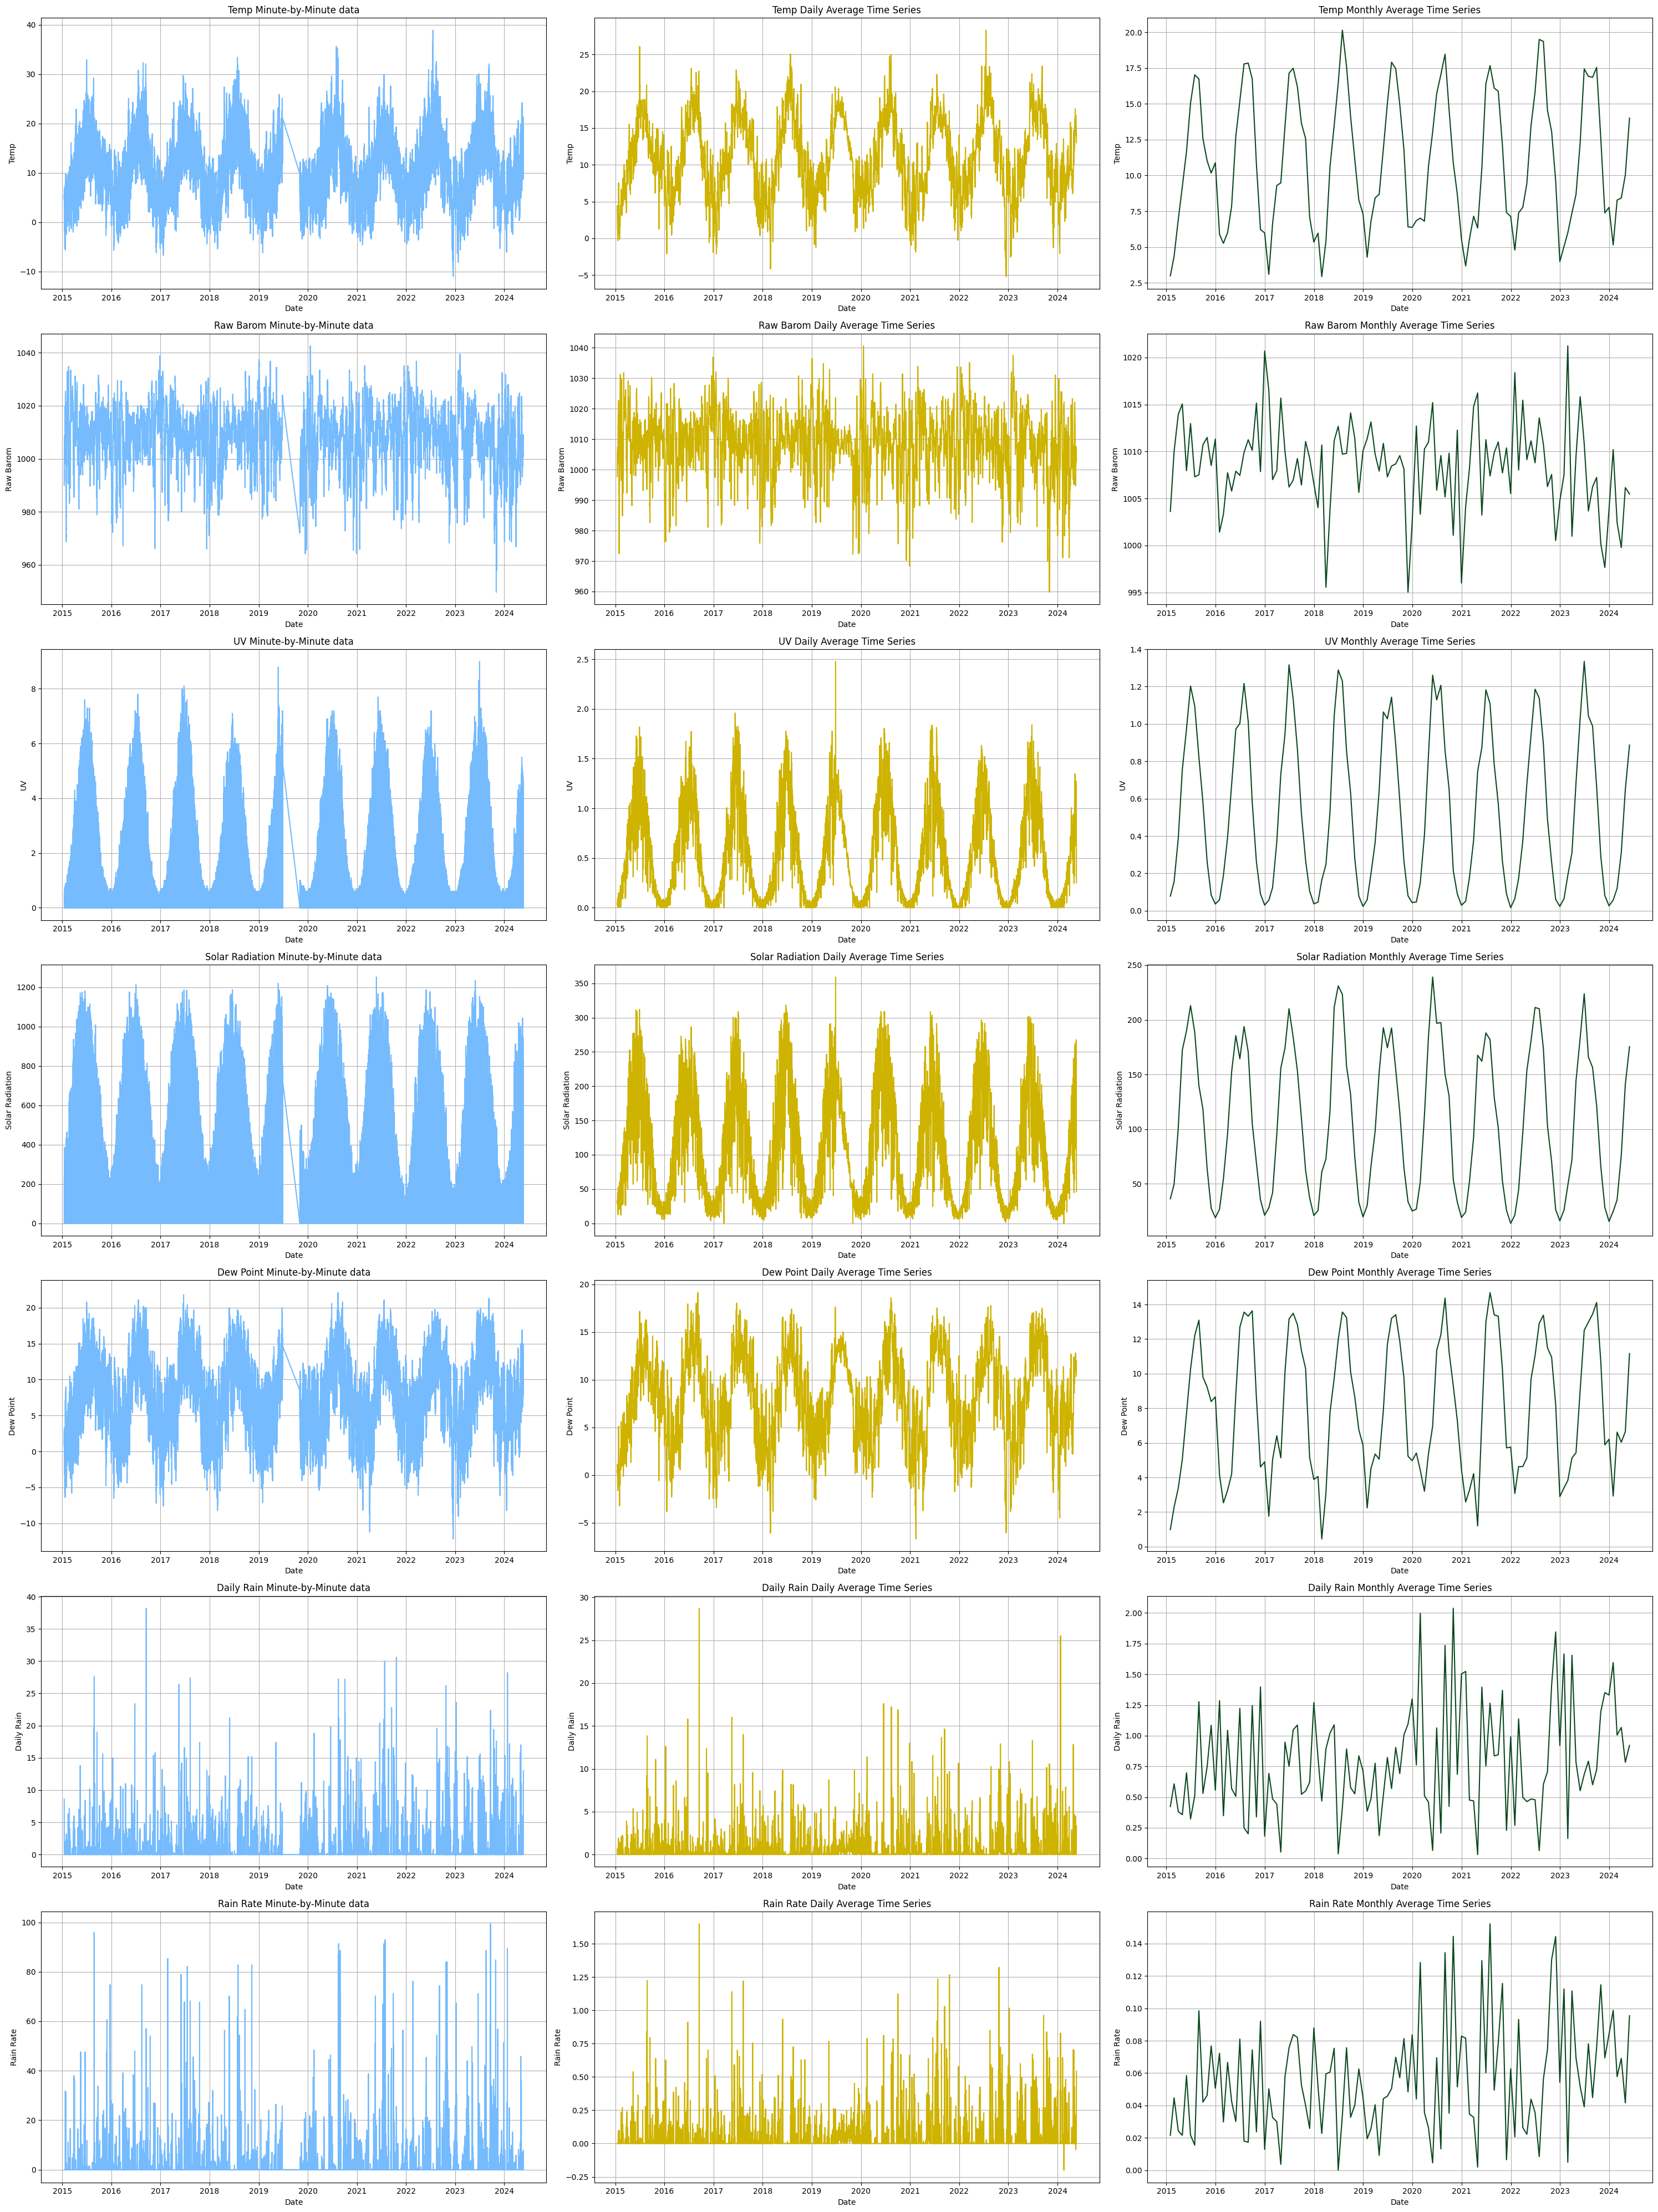

In [ ]:
#Plot second set of data
variables = ['Temp', 'Raw Barom', 'UV', 'Solar Radiation', 'Dew Point', 'Daily Rain', 'Rain Rate']
plot_time_series(met_data_clean, variables)

## **Normalising/Standardising**

In [14]:
# Normalize the data
pd.set_option('display.float_format', lambda x: '%.2f' % x)
scaler_norm = MinMaxScaler()
norm_data = daily_data_clean.copy()
norm_data = scaler_norm.fit_transform(norm_data)
norm_data = pd.DataFrame(norm_data, columns=daily_data_clean.columns, index=daily_data_clean.index)
norm_data.describe()

Wind Dir  Wind Spd  Wind Gust  Hum In  Humidity  Temp In    Temp  \
count   3414.00   3414.00    3414.00 3414.00   3414.00  3414.00 3414.00   
mean       0.56      0.22       0.26    0.49      0.72     0.50    0.48   
std        0.19      0.14       0.15    0.20      0.16     0.17    0.16   
min        0.00      0.00       0.00    0.00      0.00     0.00    0.00   
25%        0.46      0.12       0.15    0.35      0.61     0.38    0.37   
50%        0.59      0.20       0.23    0.46      0.73     0.50    0.48   
75%        0.69      0.30       0.34    0.61      0.84     0.63    0.61   
max        1.00      1.00       1.00    1.00      1.00     1.00    1.00   

       Raw Barom      UV  Solar Radiation  Dew Point  Daily Rain  Rain Rate  
count    3414.00 3414.00          3414.00    3414.00     3414.00    3414.00  
mean        0.60    0.22             0.30       0.57        0.04       0.14  
std         0.13    0.19             0.22       0.18        0.09       0.08  
min         0.00    0.00             0.00       0.00        0.00       0.00  
25%         0.53    0.05             0.10       0.43        0.00       0.11  
50%         0.62    0.17             0.25       0.58        0.01       0.11  
75%         0.69    0.35             0.47       0.71        0.04       0.13  
max         1.00    1.00             1.00       1.00        1.00       1.00

In [15]:
#Standardise the data
scaler_std = StandardScaler()
stan_data = daily_data_clean.copy()
stan_data = scaler_std.fit_transform(stan_data)
stan_data = pd.DataFrame(stan_data, columns=daily_data_clean.columns, index=daily_data_clean.index)
stan_data.describe()

Wind Dir  Wind Spd  Wind Gust  Hum In  Humidity  Temp In    Temp  \
count   3414.00   3414.00    3414.00 3414.00   3414.00  3414.00 3414.00   
mean       0.00     -0.00      -0.00   -0.00      0.00     0.00   -0.00   
std        1.00      1.00       1.00    1.00      1.00     1.00    1.00   
min       -2.96     -1.61      -1.75   -2.48     -4.48    -3.01   -3.03   
25%       -0.54     -0.73      -0.73   -0.69     -0.68    -0.72   -0.73   
50%        0.20     -0.19      -0.18   -0.15      0.10    -0.02   -0.05   
75%        0.71      0.53       0.55    0.61      0.79     0.76    0.80   
max        2.35      5.62       5.03    2.63      1.78     2.99    3.25   

       Raw Barom      UV  Solar Radiation  Dew Point  Daily Rain  Rain Rate  
count    3414.00 3414.00          3414.00    3414.00     3414.00    3414.00  
mean       -0.00    0.00            -0.00      -0.00       -0.00       0.00  
std         1.00    1.00             1.00       1.00        1.00       1.00  
min        -4.57   -1.14            -1.35      -3.13       -0.47      -1.83  
25%        -0.59   -0.89            -0.89      -0.74       -0.47      -0.40  
50%         0.09   -0.25            -0.22       0.04       -0.41      -0.40  
75%         0.66    0.72             0.75       0.80       -0.00      -0.11  
max         3.02    4.12             3.15       2.37       10.66      11.40

## **Feature Selection**

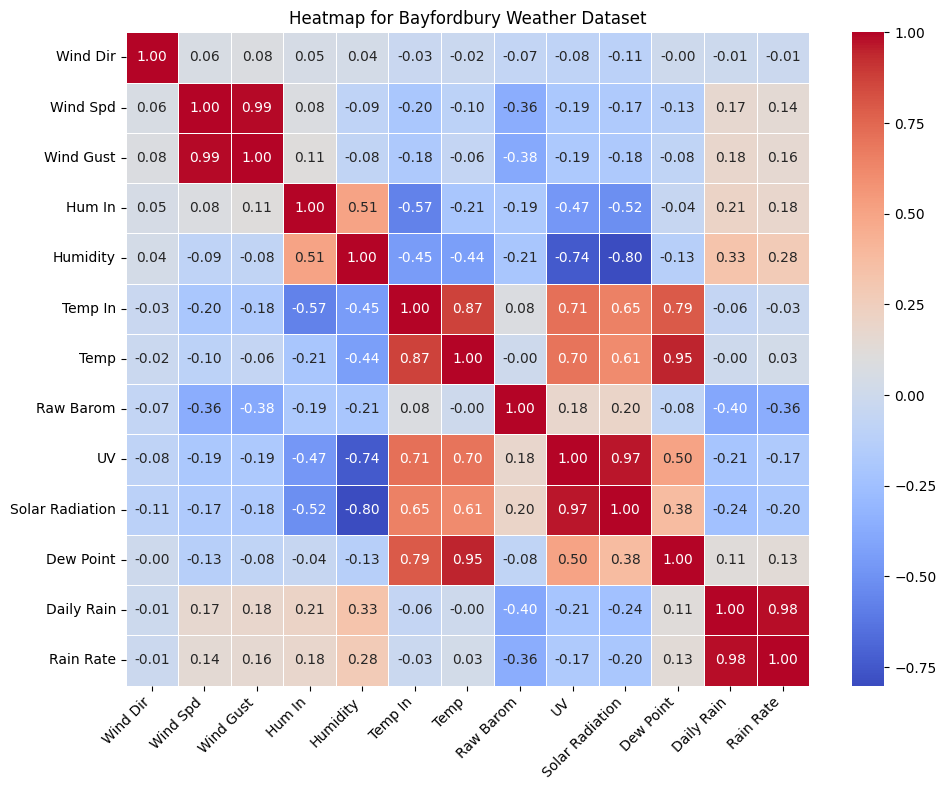

In [16]:
correlation_matrix = stan_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap for Bayfordbury Weather Dataset')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### **Temperature**

In [16]:
#Using Recursive Feature Elimination for feature selection
X = stan_data.drop(columns=['Temp'])
y = stan_data['Temp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

#RFE
model = LinearRegression()
rfe = RFE(model, n_features_to_select=6)
rfe.fit(X_train, y_train)
selected_features_rfe = X.columns[rfe.support_]
print("Selected features using RFE:", selected_features_rfe)

Selected features using RFE: Index(['Wind Spd', 'Wind Gust', 'Humidity', 'Dew Point', 'Daily Rain',
       'Rain Rate'],
      dtype='object')


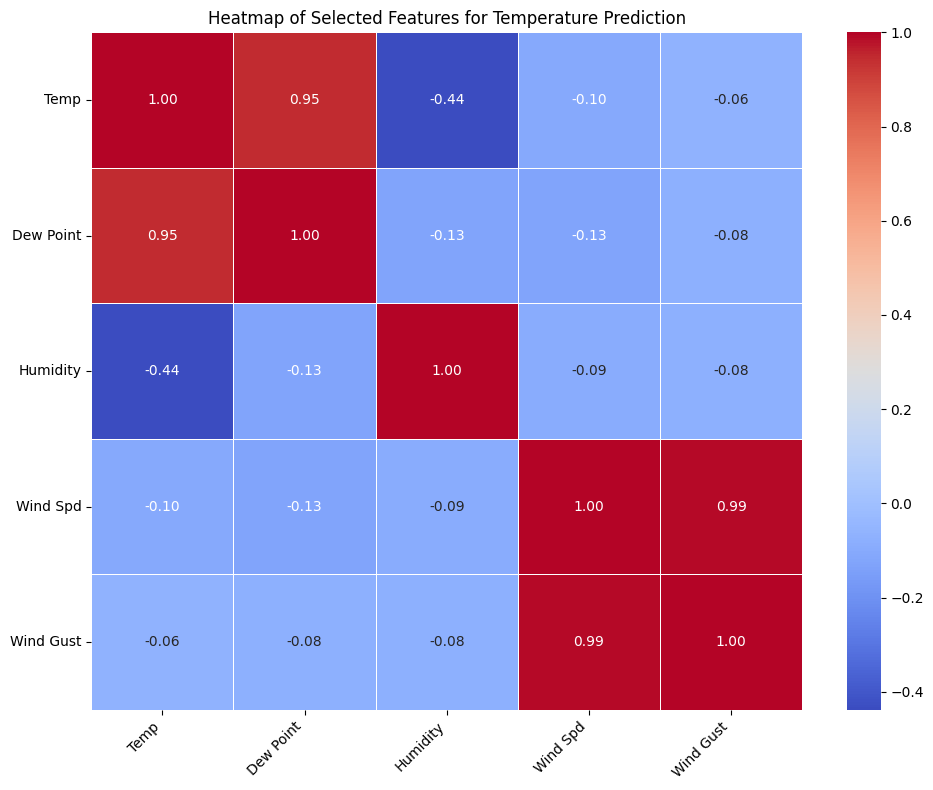

In [ ]:
#Plotting heatmap after feature selection
variables = ['Temp', 'Dew Point', 'Humidity', 'Wind Spd', 'Wind Gust']
subset_df = stan_data[variables]

correlation_matrix = subset_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap of Selected Features for Temperature Prediction')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### **Humidity**

In [19]:
X = stan_data.drop(columns=['Humidity'])
y = stan_data['Humidity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

#RFE
model = LinearRegression()
rfe = RFE(model, n_features_to_select=6)
rfe.fit(X_train, y_train)
selected_features_rfe = X.columns[rfe.support_]
print("Selected features using RFE:", selected_features_rfe)

Selected features using RFE: Index(['Wind Spd', 'Wind Gust', 'Temp', 'Dew Point', 'Daily Rain',
       'Rain Rate'],
      dtype='object')


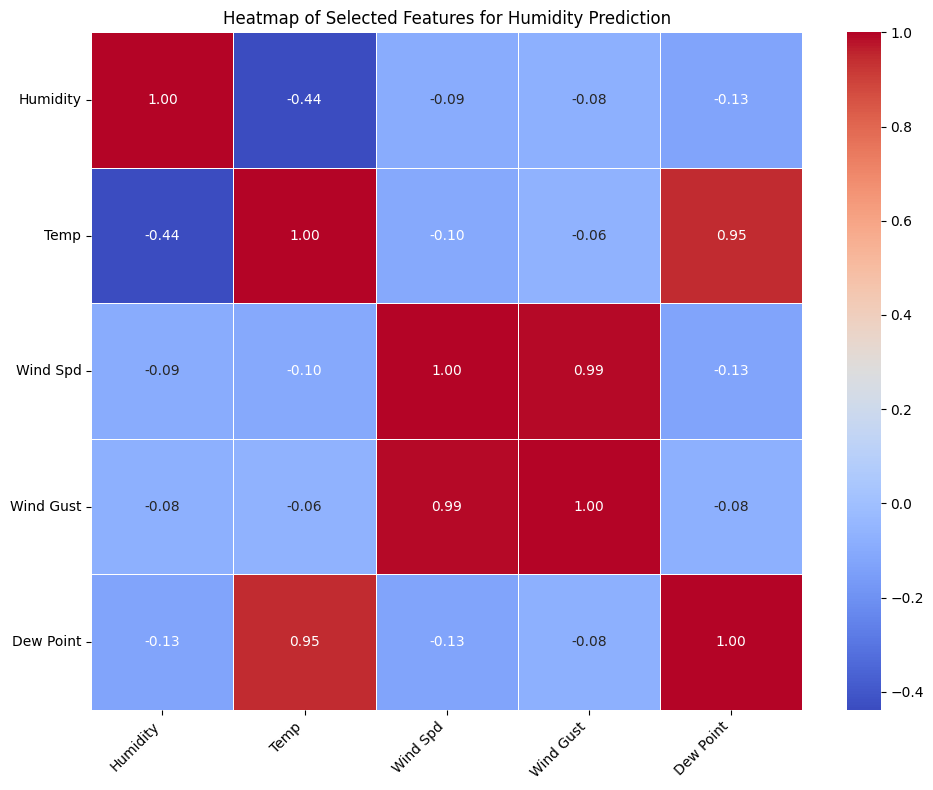

In [20]:
#Plotting heatmap after feature selection
variables = ['Humidity', 'Temp', 'Wind Spd', 'Wind Gust', 'Dew Point']
subset_df = stan_data[variables]

correlation_matrix = subset_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap of Selected Features for Humidity Prediction')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### **Daily Rain**

In [21]:
# Splitting data
X = stan_data.drop(columns=['Daily Rain'])
y = stan_data['Daily Rain']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#RFE
model = LinearRegression()
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X_train, y_train)
selected_features_rfe = X.columns[rfe.support_]
print("Selected features using RFE:", selected_features_rfe)

Selected features using RFE: Index(['Wind Spd', 'Humidity', 'Temp', 'Dew Point', 'Rain Rate'], dtype='object')


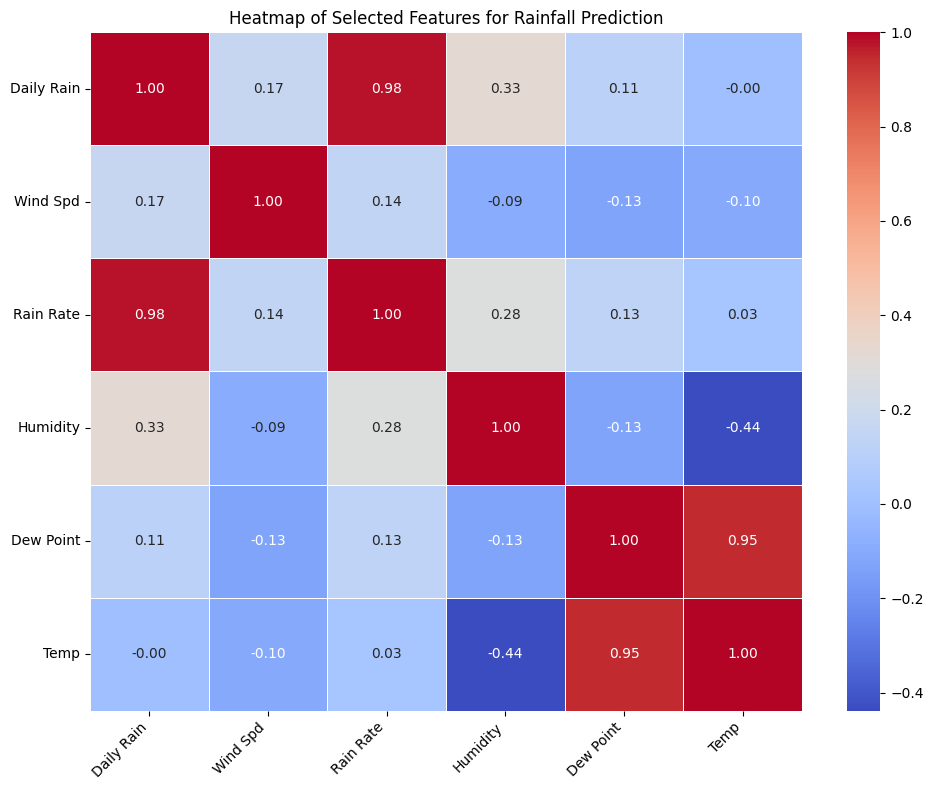

In [22]:
#Plotting heatmap after feature selection
variables = ['Daily Rain', 'Wind Spd', 'Rain Rate', 'Humidity', 'Dew Point', 'Temp']
subset_df = daily_data_clean[variables]

correlation_matrix = subset_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap of Selected Features for Rainfall Prediction')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# **MODEL** **DEVELOPMENT**

### **Multiple Linear Regression**

**Temperature**

In [17]:
X1 = stan_data.drop(columns=['Wind Dir', 'Hum In', 'Temp In', 'Temp', 'Raw Barom','UV', 'Solar Radiation', 'Daily Rain', 'Rain Rate'])
y1 = stan_data['Temp']

# Split the data into training and testing sets
split_index = int(len(stan_data) * 0.7)
X1_train = X1.iloc[:split_index]
X1_test = X1.iloc[split_index:]
y1_train = y1.iloc[:split_index]
y1_test = y1.iloc[split_index:]

In [20]:
lr1 = LinearRegression()
lr1.fit(X1_train, y1_train)

LinearRegression()

In [21]:
#To obtain coefficients, intercept and the equation for the model in the original scale of the dataset
coefficients = lr1.coef_
intercept = lr1.intercept_

features = X1.columns

# Get the corresponding scale and mean for the features
feature_scales = scaler_std.scale_[daily_data_clean.columns.get_indexer(features)]
feature_means = scaler_std.mean_[daily_data_clean.columns.get_indexer(features)]

# Calculate the original coefficients
original_coefficients = lr1.coef_ * (scaler_std.scale_[daily_data_clean.columns.get_loc('Temp')] / feature_scales)

# Adjust the intercept
original_intercept = (
    lr1.intercept_ * scaler_std.scale_[daily_data_clean.columns.get_loc('Temp')]
    + scaler_std.mean_[daily_data_clean.columns.get_loc('Temp')]
    - np.sum(original_coefficients * feature_means)
)

features = X1_train.columns
coef_df = pd.DataFrame(original_coefficients, index=features, columns=['Coefficient'])
print("Coefficients:")
print(coef_df)

# Print the intercept
print(f"Intercept: {original_intercept}")

# Construct the equation
equation = "Temp = {:.2f}".format(original_intercept)
for feature, coef in zip(features, original_coefficients):
    equation += " + ({:.2f} * {})".format(coef, feature)

print("Regression Equation:")
print(equation)

Coefficients:
           Coefficient
Wind Spd          0.04
Wind Gust        -0.04
Humidity         -0.21
Dew Point         1.03
Intercept: 20.319983696763494
Regression Equation:
Temp = 20.32 + (0.04 * Wind Spd) + (-0.04 * Wind Gust) + (-0.21 * Humidity) + (1.03 * Dew Point)


In [22]:
y1_pred_test = lr1.predict(X1_test)

# Convert the standardized predictions back to the original scale
y1_pred_test_original = (y1_pred_test * scaler_std.scale_[daily_data_clean.columns.get_loc('Temp')]) + scaler_std.mean_[daily_data_clean.columns.get_loc('Temp')]
y1_test_original = (y1_test * scaler_std.scale_[daily_data_clean.columns.get_loc('Temp')]) + scaler_std.mean_[daily_data_clean.columns.get_loc('Temp')]

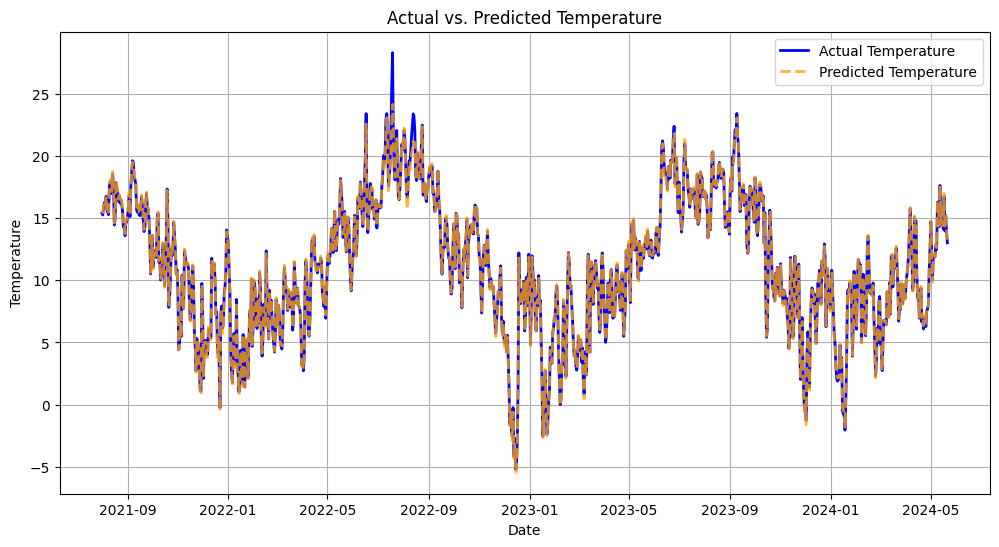

In [23]:
def plot_actual_vs_predicted(y_test, y_pred_test, variable_name='Variable'):
    """
    Plots actual vs predicted values for a given variable.

    Parameters:
    - y_test: pd.Series, actual values with a datetime index
    - y_pred_test: pd.Series or array-like, predicted values corresponding to y_test
    - variable_name: str, name of the variable being plotted
    """

    y_pred_test = pd.Series(y_pred_test, index=y_test.index)
    y_test = y_test.sort_index()
    y_pred_test = y_pred_test.sort_index()

    # Plot the time series data
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label=f'Actual {variable_name}', color='blue', linestyle='-', linewidth=2)
    plt.plot(y_pred_test.index, y_pred_test, label=f'Predicted {variable_name}', color='orange', linestyle='--', alpha=0.8,linewidth=2)

    plt.xlabel('Date')
    plt.ylabel(variable_name)
    plt.title(f'Actual vs. Predicted {variable_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_actual_vs_predicted(y1_test_original, y1_pred_test_original, variable_name='Temperature')

In [51]:
def model_performance(y_test, y_pred, variable_name='Variable'):
    """
    Evaluates the performance of a regression model and prints out the metrics.

    Parameters:
    - y_test: pd.Series or array-like, actual values
    - y_pred: pd.Series or array-like, predicted values
    - variable_name: str, name of the variable being evaluated
    """
    mean_error = np.mean(y_test - y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    average_error = np.mean([mean_error, mae, rmse])

    # Print the metrics
    print(f"Performance Metrics for {variable_name}:")
    print(f"Mean Error (ME): {mean_error:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Average Error: {average_error:.4f}")


model_performance(y1_test_original, y1_pred_test_original, variable_name='Temperature')

Performance Metrics for Temperature:
Mean Error (ME): 0.0106
Mean Absolute Error (MAE): 0.1576
Root Mean Squared Error (RMSE): 0.2823
Average Error: 0.1502


**Humidity**

In [52]:
X2 = stan_data.drop(columns=['Wind Dir', 'Hum In', 'Humidity', 'Temp In', 'Raw Barom', 'UV', 'Solar Radiation', 'Daily Rain', 'Rain Rate'])
y2 = stan_data['Humidity']

# Split the data into training and testing sets
X2_train = X2.iloc[:split_index]
X2_test = X2.iloc[split_index:]
y2_train = y2.iloc[:split_index]
y2_test = y2.iloc[split_index:]

In [53]:
lr2 = LinearRegression()
lr2.fit(X2_train, y2_train)

LinearRegression()

In [54]:
#To obtain coefficients, intercept and the equation for the model in the original scale of the dataset
coefficients = lr2.coef_
intercept = lr2.intercept_

features = X2.columns

# Get the corresponding scale and mean for the features
feature_scales = scaler_std.scale_[daily_data_clean.columns.get_indexer(features)]
feature_means = scaler_std.mean_[daily_data_clean.columns.get_indexer(features)]

# Calculate the original coefficients
original_coefficients = lr2.coef_ * (scaler_std.scale_[daily_data_clean.columns.get_loc('Humidity')] / feature_scales)

# Adjust the intercept
original_intercept = (
    lr2.intercept_ * scaler_std.scale_[daily_data_clean.columns.get_loc('Humidity')]
    + scaler_std.mean_[daily_data_clean.columns.get_loc('Humidity')]
    - np.sum(original_coefficients * feature_means)
)
features = X2_train.columns
coef_df = pd.DataFrame(original_coefficients, index=features, columns=['Coefficient'])
print("Coefficients:")
print(coef_df)

# Print the intercept
print(f"Intercept: {original_intercept}")

# Construct the equation
equation = "Humidity = {:.2f}".format(original_intercept)
for feature, coef in zip(features, original_coefficients):
    equation += " + ({:.2f} * {})".format(coef, feature)

print("Regression Equation:")
print(equation)

Coefficients:
           Coefficient
Wind Spd          0.15
Wind Gust        -0.18
Temp             -4.72
Dew Point         4.84
Intercept: 97.19304449436385
Regression Equation:
Humidity = 97.19 + (0.15 * Wind Spd) + (-0.18 * Wind Gust) + (-4.72 * Temp) + (4.84 * Dew Point)


In [56]:
y2_pred_test = lr2.predict(X2_test)

# Convert the standardized predictions back to the original scale
y2_pred_test_original = (y2_pred_test * scaler_std.scale_[daily_data_clean.columns.get_loc('Humidity')]) + scaler_std.mean_[daily_data_clean.columns.get_loc('Humidity')]
y2_test_original = (y2_test * scaler_std.scale_[daily_data_clean.columns.get_loc('Humidity')]) + scaler_std.mean_[daily_data_clean.columns.get_loc('Humidity')]

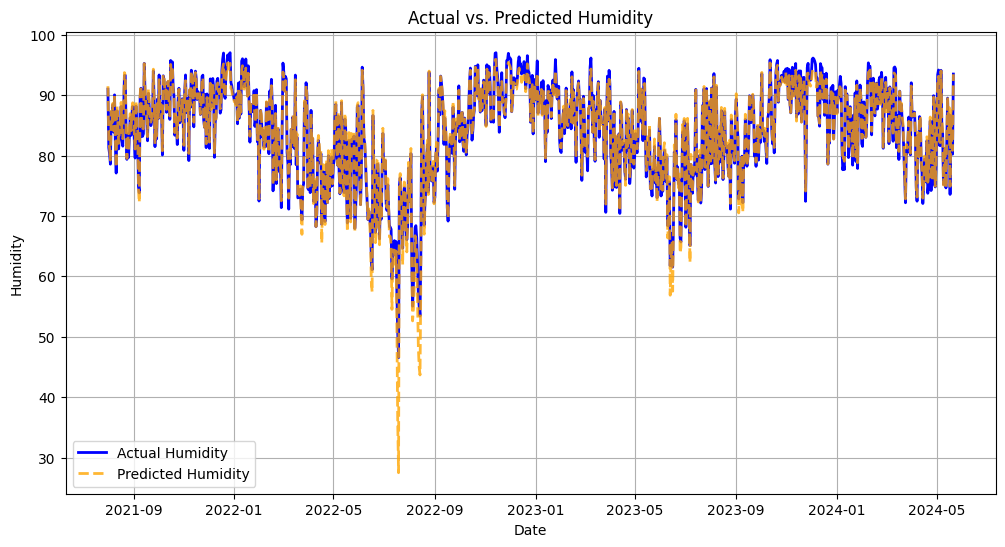

In [59]:
plot_actual_vs_predicted(y2_test_original, y2_pred_test_original, variable_name='Humidity')

In [57]:
model_performance(y2_test_original, y2_pred_test_original, variable_name='Humidity')

Performance Metrics for Humidity:
Mean Error (ME): 0.0496
Mean Absolute Error (MAE): 0.7709
Root Mean Squared Error (RMSE): 1.3170
Average Error: 0.7125


**Daily Rain**

In [58]:
X3 = stan_data.drop(columns=['Wind Dir', 'Wind Gust', 'Hum In', 'Temp In', 'Raw Barom', 'UV', 'Solar Radiation', 'Daily Rain'])
y3 = stan_data['Daily Rain']

# Split the data into training and testing sets
X3_train = X3.iloc[:split_index]
X3_test = X3.iloc[split_index:]
y3_train = y3.iloc[:split_index]
y3_test = y3.iloc[split_index:]

In [59]:
lr3 = LinearRegression()
lr3.fit(X3_train, y3_train)

LinearRegression()

In [60]:
#To obtain coefficients, intercept and the equation for the model in the original scale of the dataset
coefficients = lr3.coef_
intercept = lr3.intercept_

features = X3.columns

# Get the corresponding scale and mean for the features
feature_scales = scaler_std.scale_[daily_data_clean.columns.get_indexer(features)]
feature_means = scaler_std.mean_[daily_data_clean.columns.get_indexer(features)]

# Calculate the original coefficients
original_coefficients = lr3.coef_ * (scaler_std.scale_[daily_data_clean.columns.get_loc('Daily Rain')] / feature_scales)

# Adjust the intercept
original_intercept = (
    lr3.intercept_ * scaler_std.scale_[daily_data_clean.columns.get_loc('Daily Rain')]
    + scaler_std.mean_[daily_data_clean.columns.get_loc('Daily Rain')]
    - np.sum(original_coefficients * feature_means)
)
features = X3_train.columns
coef_df = pd.DataFrame(original_coefficients, index=features, columns=['Coefficient'])
print("Coefficients:")
print(coef_df)

# Print the intercept
print(f"Intercept: {original_intercept}")

# Construct the equation
equation = "Daily Rain = {:.2f}".format(original_intercept)
for feature, coef in zip(features, original_coefficients):
    equation += " + ({:.2f} * {})".format(coef, feature)

print("Regression Equation:")
print(equation)

Coefficients:
           Coefficient
Wind Spd          0.05
Humidity          0.13
Temp              0.49
Dew Point        -0.49
Rain Rate        23.56
Intercept: -11.985741104081779
Regression Equation:
Daily Rain = -11.99 + (0.05 * Wind Spd) + (0.13 * Humidity) + (0.49 * Temp) + (-0.49 * Dew Point) + (23.56 * Rain Rate)


In [61]:
y3_pred_test = lr3.predict(X3_test)

# Convert the standardized predictions back to the original scale
y3_pred_test_original = (y3_pred_test * scaler_std.scale_[daily_data_clean.columns.get_loc('Daily Rain')]) + scaler_std.mean_[daily_data_clean.columns.get_loc('Daily Rain')]
y3_test_original = (y3_test * scaler_std.scale_[daily_data_clean.columns.get_loc('Daily Rain')]) + scaler_std.mean_[daily_data_clean.columns.get_loc('Daily Rain')]
y3_pred_test_original = np.maximum(0, y3_pred_test_original)

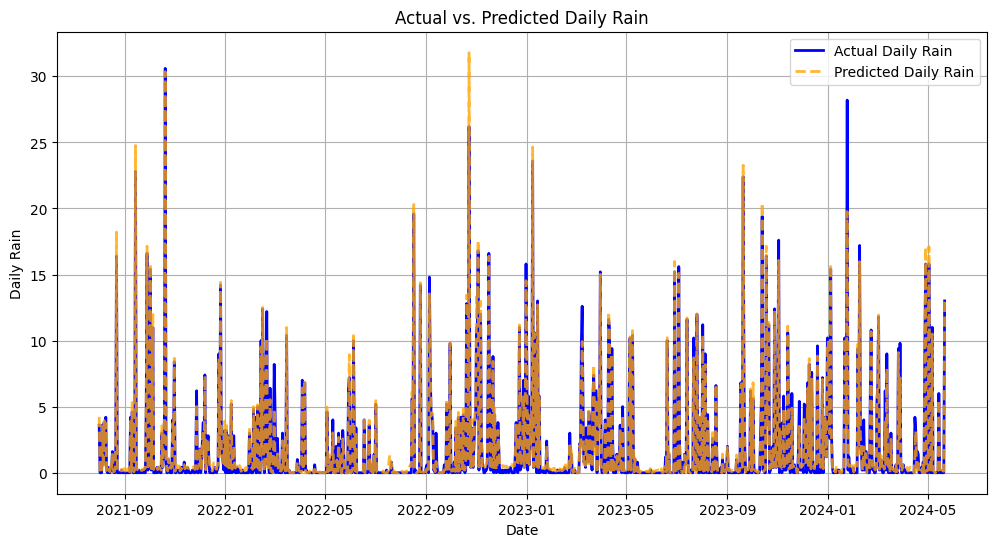

In [56]:
plot_actual_vs_predicted(y3_test_original, y3_pred_test_original, variable_name='Daily Rain')

In [62]:
model_performance(y3_test_original, y3_pred_test_original, variable_name='Daily Rain')

Performance Metrics for Daily Rain:
Mean Error (ME): -0.0420
Mean Absolute Error (MAE): 0.3291
Root Mean Squared Error (RMSE): 0.6122
Average Error: 0.2998


### **Support Vector Machines**

**Temperature**

In [63]:
X4 = stan_data.drop(columns=['Wind Dir', 'Wind Spd', 'Wind Gust', 'Hum In', 'Temp In', 'Raw Barom', 'UV', 'Solar Radiation', 'Daily Rain'])
y4 = stan_data['Temp']

# Split the data into training and testing sets
X4_train = X4.iloc[:split_index]
X4_test = X4.iloc[split_index:]
y4_train = y4.iloc[:split_index]
y4_test = y4.iloc[split_index:]

# Train the SVR model
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X4_train, y4_train)

SVR()

In [64]:
y4_pred_test = svr.predict(X4_test)

# Convert the standardized predictions back to the original scale
y4_pred_test_original = (y4_pred_test * scaler_std.scale_[daily_data_clean.columns.get_loc('Temp')]) + scaler_std.mean_[daily_data_clean.columns.get_loc('Temp')]
y4_test_original = (y4_test * scaler_std.scale_[daily_data_clean.columns.get_loc('Temp')]) + scaler_std.mean_[daily_data_clean.columns.get_loc('Temp')]

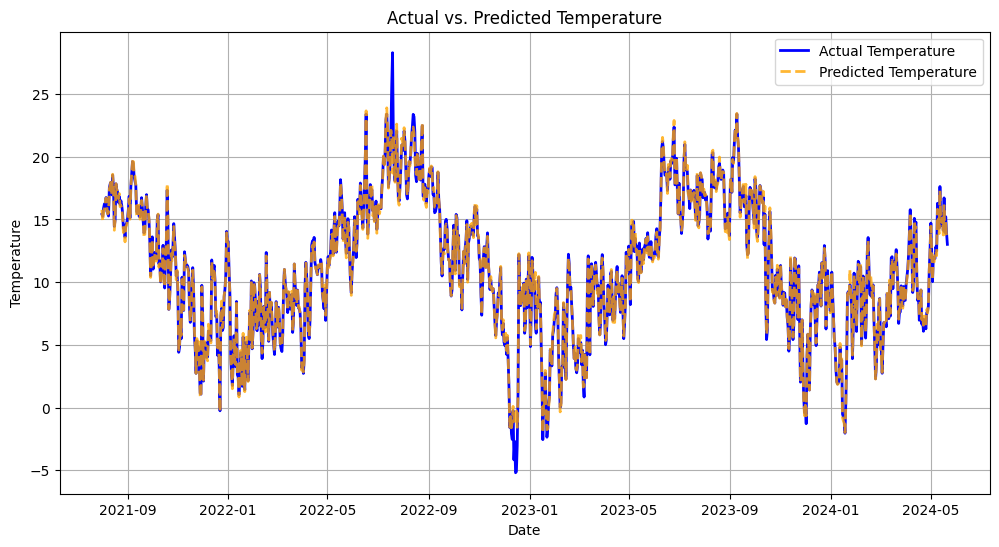

In [60]:
plot_actual_vs_predicted(y4_test_original, y4_pred_test_original, variable_name='Temperature')

In [65]:
model_performance(y4_test_original, y4_pred_test_original, variable_name='Temperature')

Performance Metrics for Temperature:
Mean Error (ME): -0.0064
Mean Absolute Error (MAE): 0.2498
Root Mean Squared Error (RMSE): 0.5138
Average Error: 0.2524


**Humidity**

In [66]:
X5 = stan_data.drop(columns=['Wind Dir', 'Hum In', 'Humidity', 'Temp In', 'Raw Barom', 'UV', 'Solar Radiation', 'Daily Rain', 'Rain Rate'])
y5 = stan_data['Humidity']

# Split the data into training and testing sets
X5_train = X5.iloc[:split_index]
X5_test = X5.iloc[split_index:]
y5_train = y5.iloc[:split_index]
y5_test = y5.iloc[split_index:]

# Train the SVR model
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X5_train, y5_train)

SVR()

In [67]:
y5_pred_test = svr.predict(X5_test)

# Convert the standardized predictions back to the original scale
y5_pred_test_original = (y5_pred_test * scaler_std.scale_[daily_data_clean.columns.get_loc('Humidity')]) + scaler_std.mean_[daily_data_clean.columns.get_loc('Humidity')]
y5_test_original = (y5_test * scaler_std.scale_[daily_data_clean.columns.get_loc('Humidity')]) + scaler_std.mean_[daily_data_clean.columns.get_loc('Humidity')]

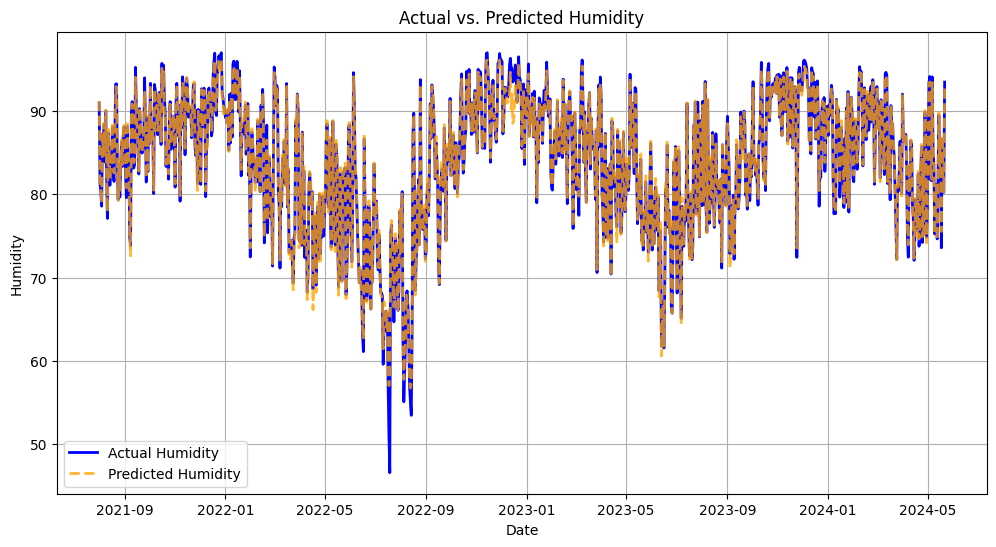

In [64]:
plot_actual_vs_predicted(y5_test_original, y5_pred_test_original, variable_name='Humidity')

In [68]:
model_performance(y5_test_original, y5_pred_test_original, variable_name='Humidity')

Performance Metrics for Humidity:
Mean Error (ME): -0.0851
Mean Absolute Error (MAE): 0.5117
Root Mean Squared Error (RMSE): 0.8422
Average Error: 0.4229


**Daily Rain**

In [69]:
X6 = stan_data.drop(columns=['Wind Dir', 'Wind Gust', 'Hum In', 'Temp In', 'Raw Barom', 'UV', 'Solar Radiation', 'Daily Rain'])
y6 = stan_data['Daily Rain']

# Split the data into training and testing sets
X6_train = X6.iloc[:split_index]
X6_test = X6.iloc[split_index:]
y6_train = y6.iloc[:split_index]
y6_test = y6.iloc[split_index:]

# Train the SVR model
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X6_train, y6_train)

SVR()

In [70]:
y6_pred_test = svr.predict(X6_test)

# Convert the standardized predictions back to the original scale
y6_pred_test_original = (y6_pred_test * scaler_std.scale_[daily_data_clean.columns.get_loc('Daily Rain')]) + scaler_std.mean_[daily_data_clean.columns.get_loc('Daily Rain')]
y6_test_original = (y6_test * scaler_std.scale_[daily_data_clean.columns.get_loc('Daily Rain')]) + scaler_std.mean_[daily_data_clean.columns.get_loc('Daily Rain')]
y6_pred_test_original = np.maximum(0, y6_pred_test_original)

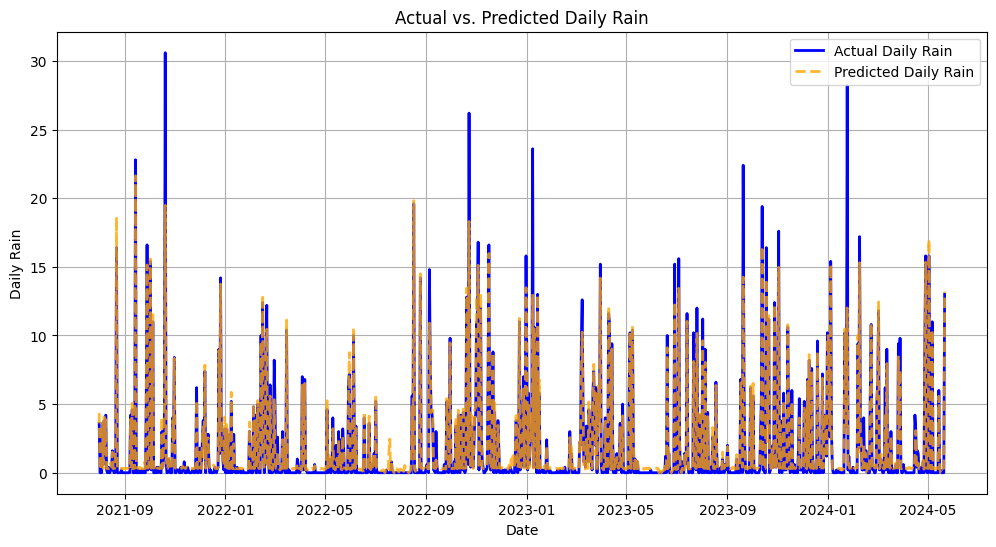

In [76]:
plot_actual_vs_predicted(y6_test_original, y6_pred_test_original, variable_name='Daily Rain')

In [71]:
model_performance(y6_test_original, y6_pred_test_original, variable_name='Daily Rain')

Performance Metrics for Daily Rain:
Mean Error (ME): -0.0363
Mean Absolute Error (MAE): 0.4300
Root Mean Squared Error (RMSE): 0.9660
Average Error: 0.4532


### **Artificial Neural Networks**

**Temperature**

In [72]:
X7 = stan_data.drop(columns=['Wind Dir', 'Hum In', 'Temp In', 'Temp', 'Raw Barom','UV', 'Solar Radiation', 'Daily Rain', 'Rain Rate'])
y7 = stan_data['Temp']

# Split the data into training and testing sets
X7_train = X7.iloc[:split_index]
X7_test = X7.iloc[split_index:]
y7_train = y7.iloc[:split_index]
y7_test = y7.iloc[split_index:]

model = Sequential()

# Input layer
model.add(Dense(units=64, activation='relu', input_shape=(X7_train.shape[1],)))

# Hidden layers
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X7_train, y7_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7665 - mae: 0.6668
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145 - mae: 0.0906
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - mae: 0.0494
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - mae: 0.0396
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - mae: 0.0310
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - mae: 0.0268
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6357e-04 - mae: 0.0230
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4314e-04 - mae: 0.0210
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8934e-04 - mae: 0.0218
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6458e-04 - mae: 0.0199
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6822e-04 - mae: 0.0193
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9287e-04 - mae: 0.0174
Epoch 13/50
75/75 ━━━━━━━━━━━━━━━━━━

In [73]:
y7_pred_test = model.predict(X7_test)

# Convert the standardized predictions back to the original scale
y7_pred_test_original = (y7_pred_test * scaler_std.scale_[daily_data_clean.columns.get_loc('Temp')]) + scaler_std.mean_[daily_data_clean.columns.get_loc('Temp')]
y7_test_original = (y7_test * scaler_std.scale_[daily_data_clean.columns.get_loc('Temp')]) + scaler_std.mean_[daily_data_clean.columns.get_loc('Temp')]

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


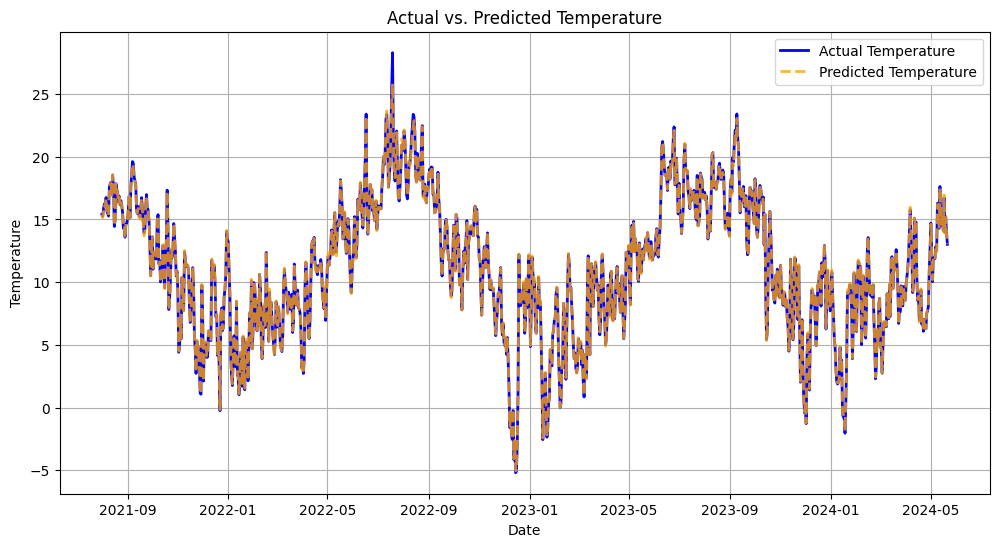

In [74]:
plot_actual_vs_predicted(y7_test_original, y7_pred_test_original.flatten(), variable_name='Temperature')

In [75]:
model_performance(y7_test_original, y7_pred_test_original.flatten(), variable_name='Temperature')

Performance Metrics for Temperature:
Mean Error (ME): -0.0086
Mean Absolute Error (MAE): 0.0917
Root Mean Squared Error (RMSE): 0.1469
Average Error: 0.0766


**Humidity**

In [76]:
X8 = stan_data.drop(columns=['Wind Dir', 'Hum In', 'Humidity', 'Temp In', 'Raw Barom', 'UV', 'Solar Radiation', 'Daily Rain', 'Rain Rate'])
y8 = stan_data['Humidity']

# Split the data into training and testing sets
X8_train = X8.iloc[:split_index]
X8_test = X8.iloc[split_index:]
y8_train = y8.iloc[:split_index]
y8_test = y8.iloc[split_index:]

model = Sequential()

# Input layer
model.add(Dense(units=64, activation='relu', input_shape=(X8_train.shape[1],)))

# Hidden layers
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X8_train, y8_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7640 - mae: 0.7042
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0536 - mae: 0.1600
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107 - mae: 0.0773
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - mae: 0.0720
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - mae: 0.0639
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - mae: 0.0573
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049 - mae: 0.0536
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - mae: 0.0514
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - mae: 0.0479
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - mae: 0.0489
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - mae: 0.0474
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - mae: 0.0440
Epoch 13/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0

In [77]:
y8_pred_test = model.predict(X8_test)

# Convert the standardized predictions back to the original scale
y8_pred_test_original = (y8_pred_test * scaler_std.scale_[daily_data_clean.columns.get_loc('Humidity')]) + scaler_std.mean_[daily_data_clean.columns.get_loc('Humidity')]
y8_test_original = (y8_test * scaler_std.scale_[daily_data_clean.columns.get_loc('Humidity')]) + scaler_std.mean_[daily_data_clean.columns.get_loc('Humidity')]

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


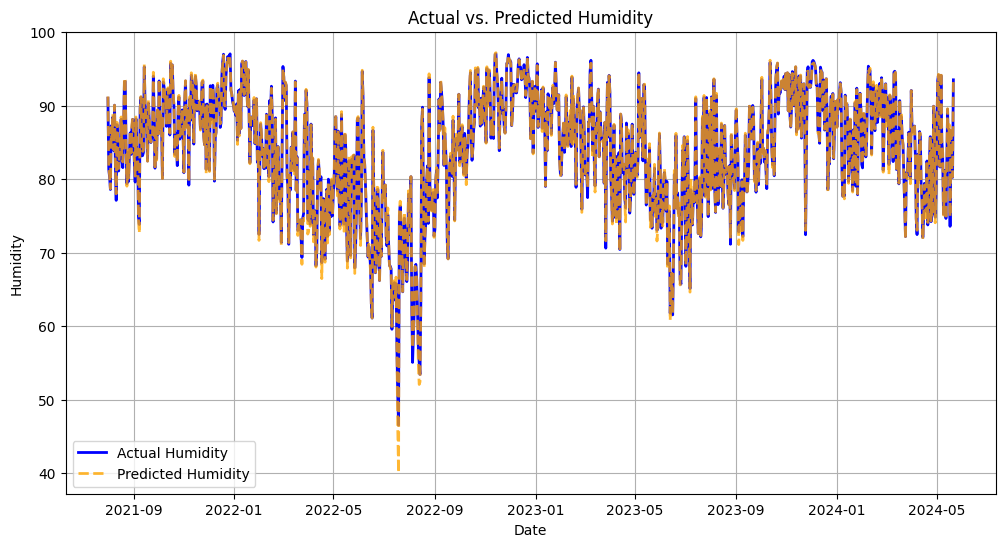

In [78]:
plot_actual_vs_predicted(y8_test_original, y8_pred_test_original.flatten(), variable_name='Humidity')

In [79]:
model_performance(y8_test_original, y8_pred_test_original.flatten(), variable_name='Humidity')

Performance Metrics for Humidity:
Mean Error (ME): -0.0240
Mean Absolute Error (MAE): 0.3118
Root Mean Squared Error (RMSE): 0.4938
Average Error: 0.2605


In [80]:
X9 = stan_data.drop(columns=['Wind Dir', 'Wind Gust', 'Hum In', 'Temp In', 'Raw Barom', 'UV', 'Solar Radiation', 'Daily Rain'])
y9 = stan_data['Daily Rain']

# Split the data into training and testing sets
X9_train = X9.iloc[:split_index]
X9_test = X9.iloc[split_index:]
y9_train = y9.iloc[:split_index]
y9_test = y9.iloc[split_index:]

model = Sequential()

# Input layer
model.add(Dense(units=64, activation='relu', input_shape=(X9_train.shape[1],)))

# Hidden layers
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X9_train, y9_train, epochs=50, batch_size=32,verbose=1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4820 - mae: 0.4507
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0411 - mae: 0.1130
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0364 - mae: 0.1072
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0474 - mae: 0.1109
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0277 - mae: 0.0926
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0334 - mae: 0.0963
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263 - mae: 0.0929
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0370 - mae: 0.0996
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0236 - mae: 0.0901
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0262 - mae: 0.0918
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0339 - mae: 0.0966
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0281 - mae: 0.0971
Epoch 13/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0

In [81]:
y9_pred_test = model.predict(X9_test)

# Convert the standardized predictions back to the original scale
y9_pred_test_original = (y9_pred_test * scaler_std.scale_[daily_data_clean.columns.get_loc('Daily Rain')]) + scaler_std.mean_[daily_data_clean.columns.get_loc('Daily Rain')]
y9_test_original = (y9_test * scaler_std.scale_[daily_data_clean.columns.get_loc('Daily Rain')]) + scaler_std.mean_[daily_data_clean.columns.get_loc('Daily Rain')]
y9_pred_test_original = np.maximum(0, y9_pred_test_original)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


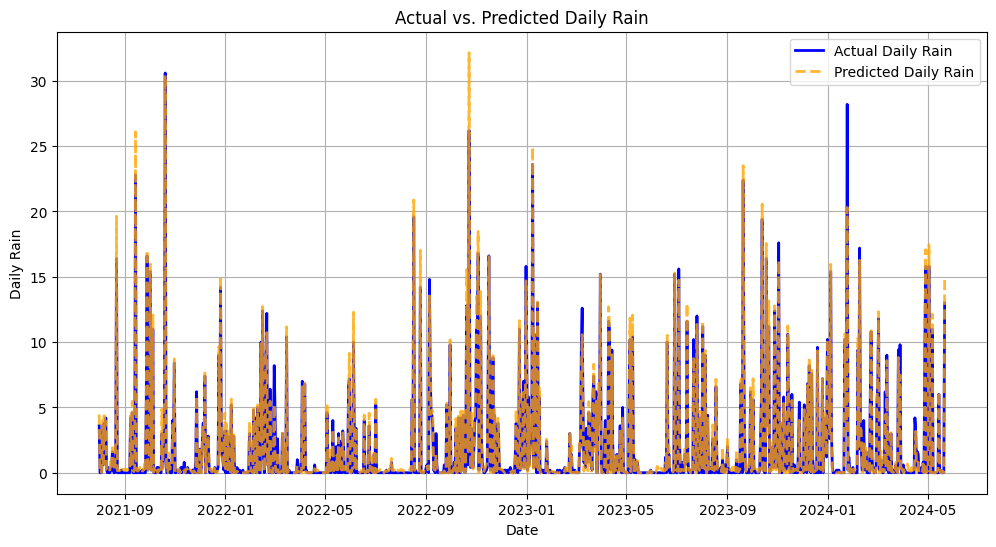

In [82]:
plot_actual_vs_predicted(y9_test_original, y9_pred_test_original.flatten(), variable_name='Daily Rain')

In [83]:
model_performance(y9_test_original, y9_pred_test_original.flatten(), variable_name='Daily Rain')

Performance Metrics for Daily Rain:
Mean Error (ME): -0.0850
Mean Absolute Error (MAE): 0.3374
Root Mean Squared Error (RMSE): 0.6504
Average Error: 0.3009
